# 0 - Imports and Read in Data

In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For tesxt:
import re

# For times:
import time

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
lstn = pd.read_csv('../data/prepped_training.csv')

In [3]:
validation = pd.read_csv('../data/prepped_validation.csv')

# 1 - General Overview

## <font color = 'red'> Talk About Evaluation Metrics

## <font color = 'red'> What's in this notebook/process

# 2 - Feature Selection with Correlation Coefficients

## 2.1 - Correlations Between All Features and Price/Log Price
The correlation coefficients between each of the features and both the price and log price will be calculated.  This is part of a quantitative feature selection process where only the most highly-correlated values will be selected to go in the model.  Correlation magnitudes (importances) will be calculated such that the features can be sorted by their importance.

In [4]:
# The code below will aggregate the correlation coefficients between all columns which are not
#  price and log_price vs. price and log price

# This code using dictionaries was written with the help of the following sourece:
#  https://www.guru99.com/python-dictionary-append.html
corr_dict = {'name': [], 'price_corr':[], 'log_price_corr': [], 'magnitude': [], 'which': []}

# Get a list of all the columns to iterate through, remvoe price and log_price
col_list = list(lstn.columns)
col_list.remove('price')
col_list.remove('log_price')

# This loop creates data for each column
for col in col_list:
    
    # Find correlations to price and log_price
    p_corr = np.corrcoef(lstn[col], lstn['price'])[0][1]
    lp_corr = np.corrcoef(lstn[col], lstn['log_price'])[0][1]
    
    # Repor the higher magnitude value
    mag = max(abs(p_corr), abs(lp_corr))
    
    # Append the above data to the dictionary
    corr_dict['name'].append(col)
    corr_dict['price_corr'].append(p_corr)
    corr_dict['log_price_corr'].append(lp_corr)
    corr_dict['magnitude'].append(mag)
    
    # The if statement below will print which correaltion is stronger
    if abs(p_corr) > abs(lp_corr):
        corr_dict['which'].append('price')
    
    else:
        corr_dict['which'].append('log_price')

# Create a dataframe from the dictionary
corr_df = pd.DataFrame(corr_dict)

# Set the index to be the column names collected as there is no need for a numerical index
corr_df.set_index('name', inplace=True)
corr_df.head()

price_corr  log_price_corr  magnitude      which
name                                                                       
host_since                   0.039550        0.027396   0.039550      price
host_response_rate          -0.003495        0.041759   0.041759  log_price
host_acceptance_rate         0.130797        0.271477   0.271477  log_price
host_listings_count          0.016601        0.136672   0.136672  log_price
host_total_listings_count   -0.011012        0.082024   0.082024  log_price

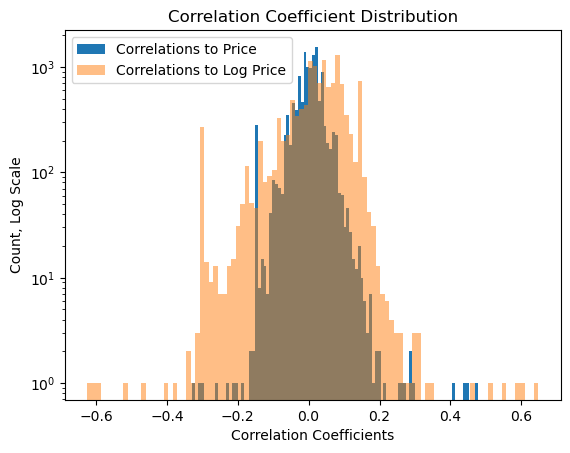

In [5]:
# Plot an overlapping histogram of the correlation distributions
plt.hist(corr_df.price_corr, bins = 100, label = 'Correlations to Price')
plt.hist(corr_df.log_price_corr, bins = 100, alpha = 0.5, label = 'Correlations to Log Price')
plt.title('Correlation Coefficient Distribution')
plt.xlabel('Correlation Coefficients')
plt.ylabel('Count, Log Scale')
plt.yscale('log')
plt.legend()
plt.show();

## 2.2 - Feature Selection/Visualization Functions

In [6]:
'''
This function will:
* Create a list (A.K.A. "feature set") of the top n number of highly correlated features
* Optionally check ommit features which are highly correlated (per some set limit) to
features already in the feature set
'''

def top_features(num_ft, check_mc, corr_lim):

    # Create a dataframe sorted by the correlation magnitude
    corr_df_sorted = corr_df.sort_values(by = 'magnitude', ascending=False)

    # Create an empty list to store the column names
    feature_set = []

    # Create an index to loop through
    bc_index = 0

    # Write a while loop to get the top 30 most highly correlated columns which are
    #  not already duplicated in the list with either their log or non-log counterparts
    while len(feature_set) < num_ft:

        # simplify the name of the individual column names pulled out of the df index
        next_column = corr_df_sorted.index[bc_index]

        # If the log version not is already there, and if the non-log version of the colunm
        #  name are not already there, then add the column name
        if f'log_{next_column}' not in feature_set and next_column.replace('log_', '') not in feature_set:
            
            # Create an if statement to skip the multi-colinearity check when adding the very-first feature
            #  Ensure that check_mc is set to True, otherwise, skip this step
            if bc_index > 0 and check_mc == True:
                
                # Create an empty list to contain the correlation coefficients
                corrcoefs = []
                
                # Loop throug and calculate the correlation coefficients of the new feature
                #  versus all currently in the feature list
                for col_no_mc in feature_set:
                    
                    # Find the correlation coefficient
                    corr_mc = np.corrcoef(lstn[next_column], lstn[col_no_mc])[0][1]
                    
                    # Add it to the corrcoefs list
                    corrcoefs.append(abs(corr_mc))

                # Set a multi-collinearity correlation coefficient limit and only accept features
                #  with correlation coefficients less than this value
                if max(corrcoefs) < corr_lim:
                    feature_set.append(next_column)
                    
            # If it is 0, then just add the first feature
            else:
                feature_set.append(next_column)

        # Increase the index value by 1
        bc_index += 1

    # Return the list of correlation coefficients
    return feature_set

In [7]:
'''
This function will take a provided column list and plot the correlation matrix.
It will also add the price and log price so that correlations between those target
variables and the features can be seen for reference.
'''

def plot_corr_matrix(col_list, fig_size):
    # Make a dataframe with just the desred columns
    corr_mat_df = lstn[col_list]
    
    # Add the price and log price data
    corr_mat_df['price'] = lstn['price']
    corr_mat_df['log_price'] = lstn['log_price']
    
    # Plot a correlation matrix
    #  From Lesson 1.07 - # This code is taken with minor modifications from https://seaborn.pydata.org/generated/seaborn.heatmap.html
    mask = np.zeros_like(corr_mat_df.corr())
    mask[np.triu_indices_from(mask)] = True
    
    plt.figure(figsize = fig_size)
    sns.heatmap(corr_mat_df.corr(), 
                annot = True, 
                fmt='.1f', # Source for "fmt='.2f'":  https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format
                cmap = 'coolwarm', 
                mask = mask)

## 2.3 - Check Top 30 Features Prior to Eliminating Multi-Colinearity

In [8]:
# Using the defined function, check the collinearity between the top 30 features

# To keep colinear features, set the corr_lim to 1
correlation_limit = 1
top_30_ft = top_features(30, check_mc=False, corr_lim = correlation_limit)

C:\Users\Dan\AppData\Local\Temp\ipykernel_15000\198349494.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_mat_df['price'] = lstn['price']
C:\Users\Dan\AppData\Local\Temp\ipykernel_15000\198349494.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_mat_df['log_price'] = lstn['log_price']


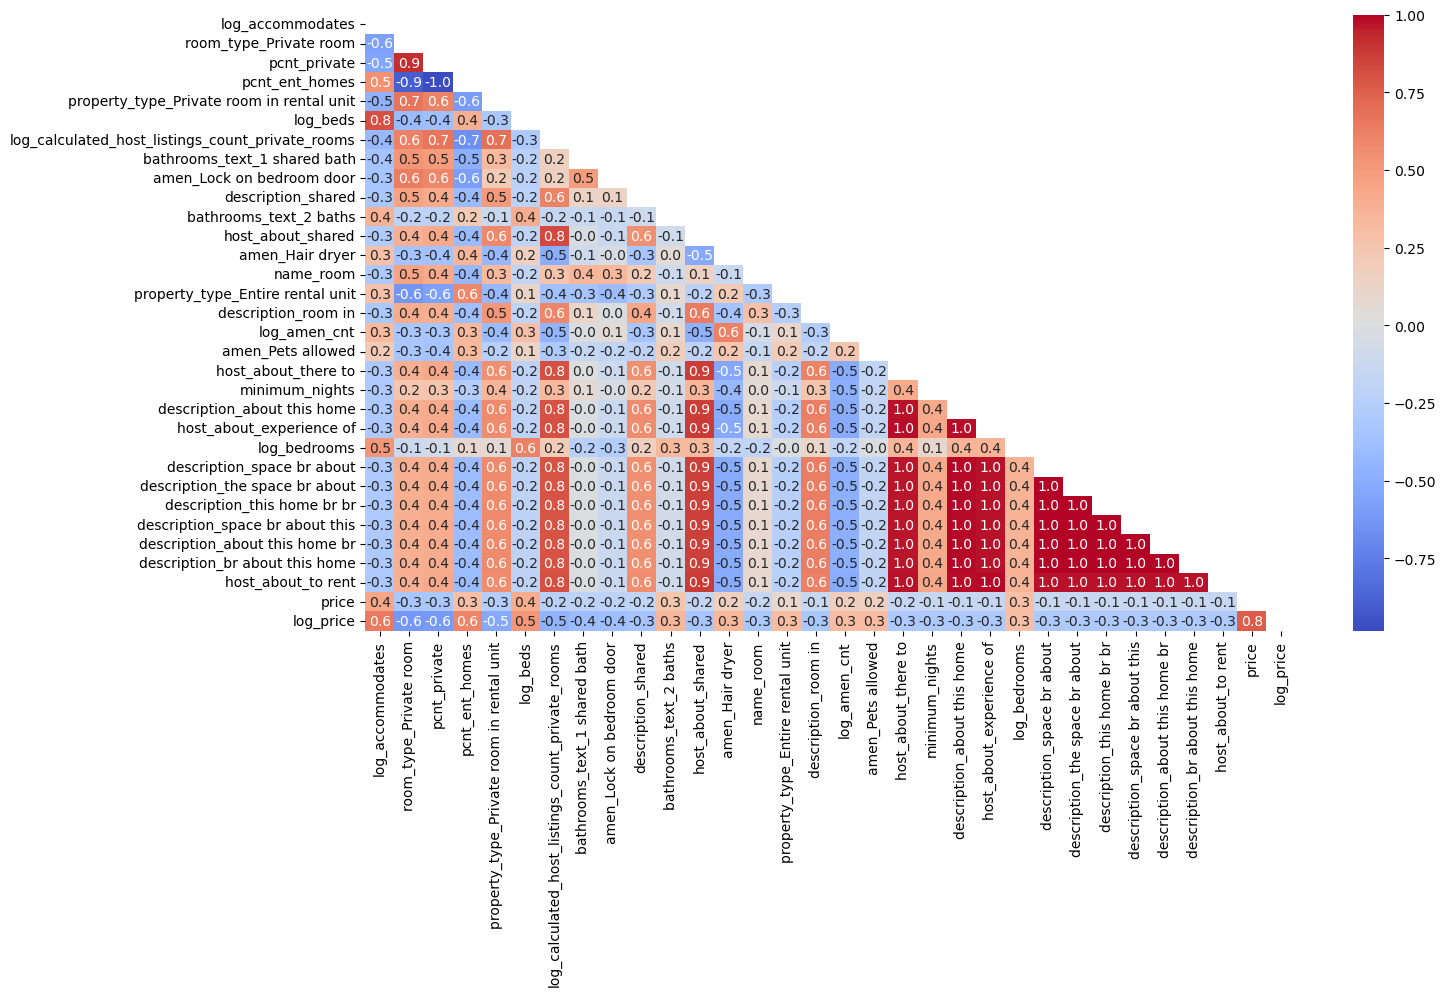

In [9]:
plot_corr_matrix(top_30_ft, (15,8))

#### OBSERVATIONS:
Many of the host variables are almost perfectly correlated with one-another.  They should be removed as they would not add any additional fidelity to the eventual models. 

## 2.4 - Filter Out Collinear Features and Refine Multicollinearity Correaltion Limit 

### 2.4.1 - Remove Features Correlated to Each Other with Correlation Coefficients (A.K.A Multicollinearity Limit) Above 0.7

In [10]:
# Find the top 30 most higlhy correlated features where there is no multicollinearity.

# Start with a correlation coefficient limit of 0.7
correlation_limit = 0.7

top_30_ft_no_mc = top_features(30, check_mc=True, corr_lim = correlation_limit)

C:\Users\Dan\AppData\Local\Temp\ipykernel_15000\198349494.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_mat_df['price'] = lstn['price']
C:\Users\Dan\AppData\Local\Temp\ipykernel_15000\198349494.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_mat_df['log_price'] = lstn['log_price']


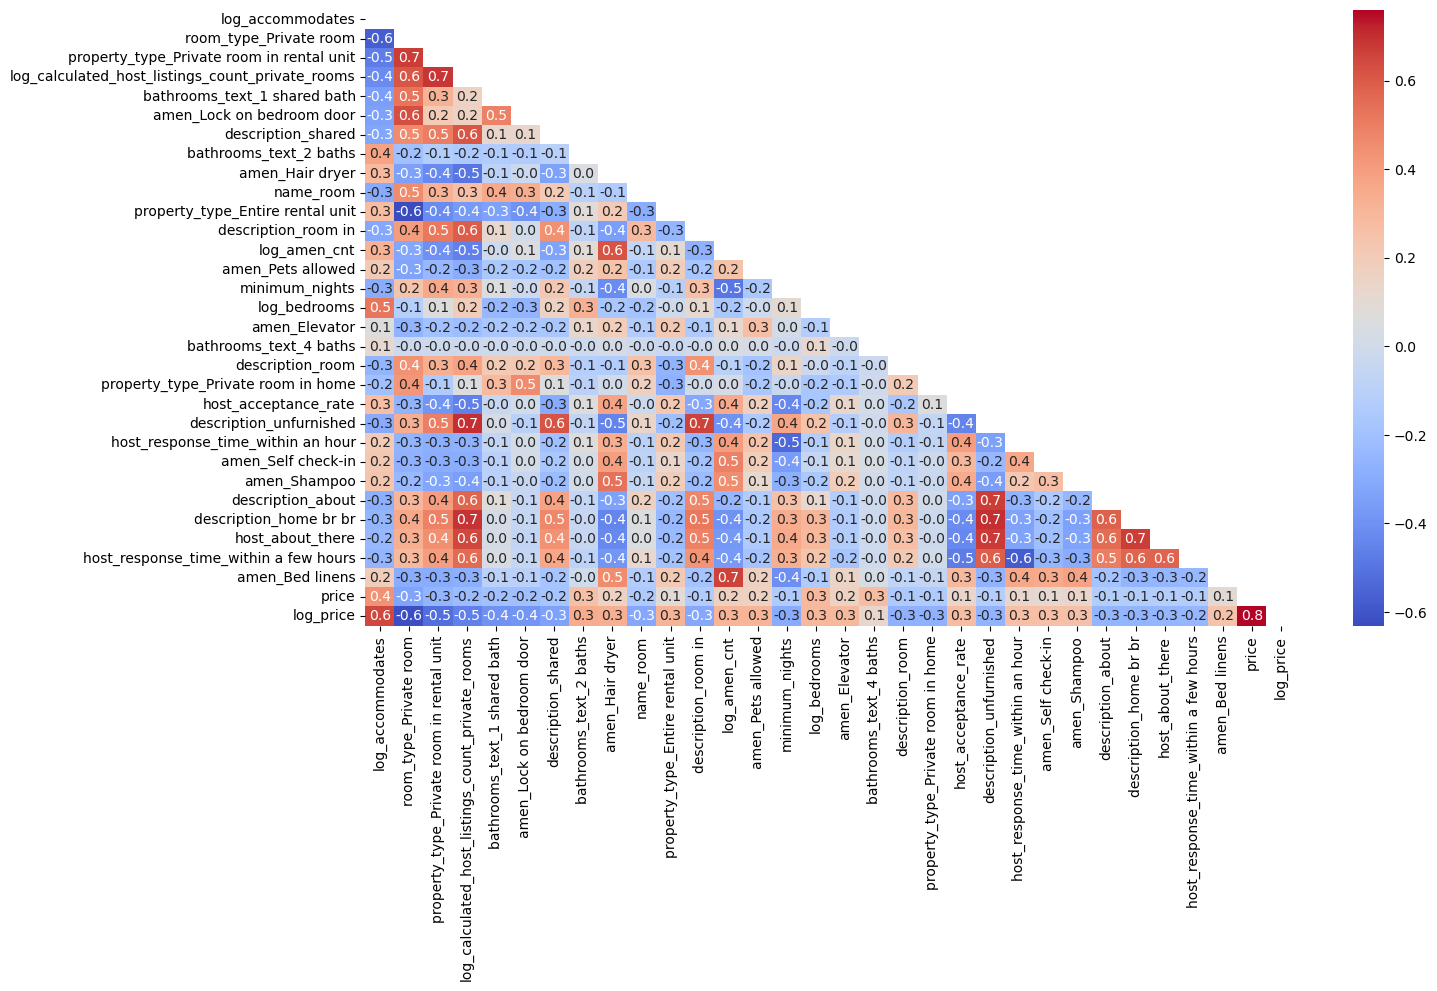

In [11]:
plot_corr_matrix(top_30_ft_no_mc, (15,8))

### 2.4.2 - Refine the Multicollinearity Limit

In [12]:
# Find the top 30 most higlhy correlated features where there is no multicollinearity.

# Start with a correlation coefficient limit of 0.7
correlation_limit = 0.5

top_30_ft_no_mc = top_features(30, check_mc=True, corr_lim = correlation_limit)

C:\Users\Dan\AppData\Local\Temp\ipykernel_15000\198349494.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_mat_df['price'] = lstn['price']
C:\Users\Dan\AppData\Local\Temp\ipykernel_15000\198349494.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_mat_df['log_price'] = lstn['log_price']


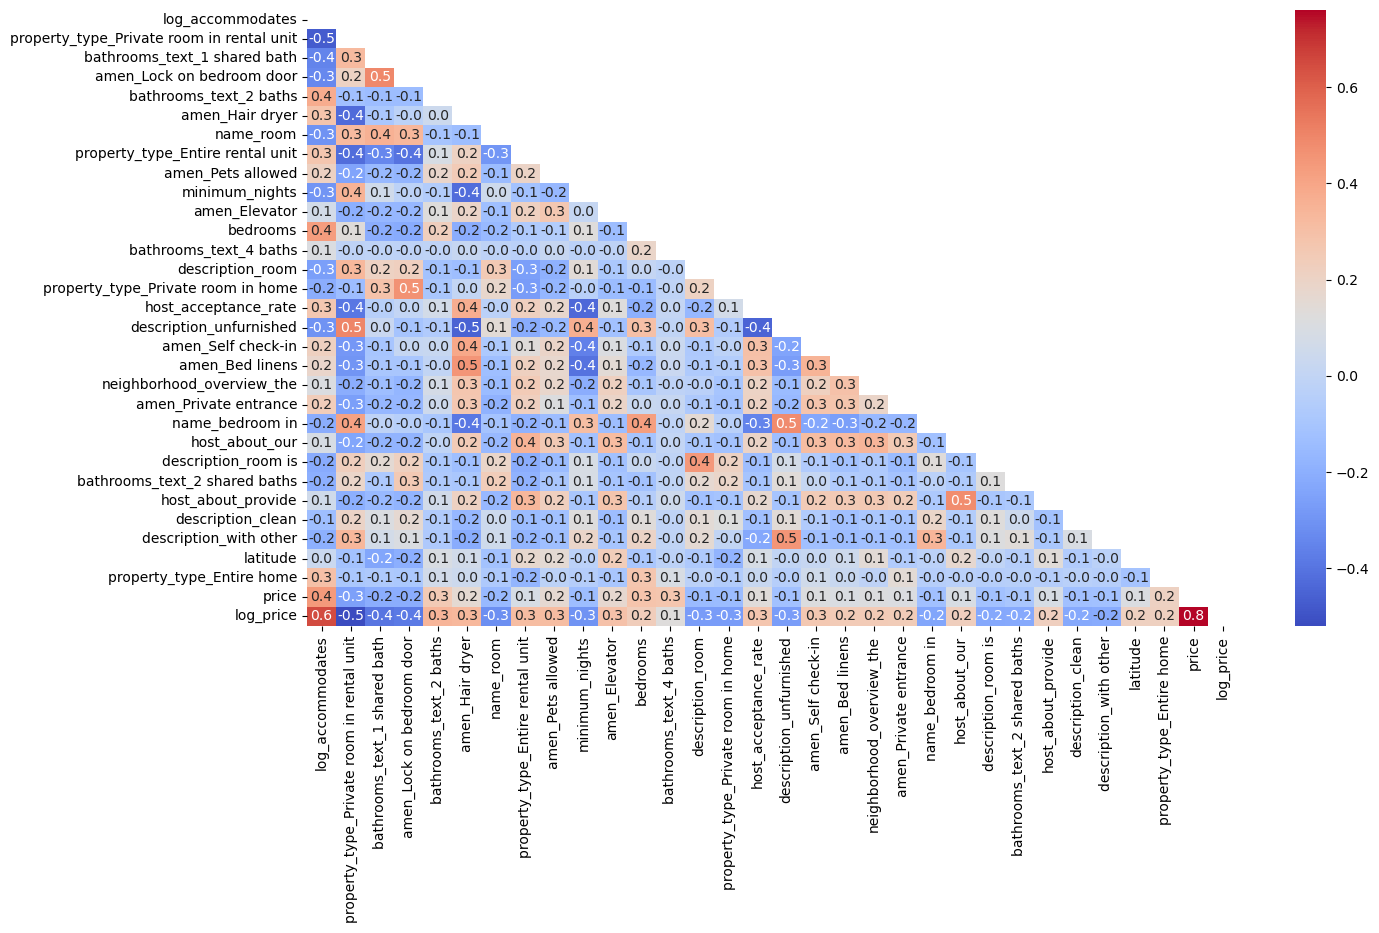

In [13]:
plot_corr_matrix(top_30_ft_no_mc, (15,8))

In [14]:
# View the 30 most highly correlated variables above in the correlation dataframe
corr_df.loc[top_30_ft_no_mc]

price_corr  log_price_corr  \
name                                                                    
log_accommodates                             0.437727        0.647343   
property_type_Private room in rental unit   -0.258554       -0.519602   
bathrooms_text_1 shared bath                -0.207068       -0.397327   
amen_Lock on bedroom door                   -0.208319       -0.381361   
bathrooms_text_2 baths                       0.254731        0.342915   
amen_Hair dryer                              0.156992        0.335156   
name_room                                   -0.156941       -0.315639   
property_type_Entire rental unit             0.089294        0.315240   
amen_Pets allowed                            0.162390        0.310873   
minimum_nights                              -0.144075       -0.304003   
amen_Elevator                                0.166448        0.291888   
bedrooms                                     0.285075        0.230932   
bathrooms_text_4 baths                       0.275243        0.128703   
description_room                            -0.149926       -0.274316   
property_type_Private room in home          -0.147431       -0.273557   
host_acceptance_rate                         0.130797        0.271477   
description_unfurnished                     -0.124157       -0.266908   
amen_Self check-in                           0.112296        0.262333   
amen_Bed linens                              0.101560        0.245900   
neighborhood_overview_the                    0.110616        0.245732   
amen_Private entrance                        0.106345        0.244561   
name_bedroom in                             -0.127765       -0.235728   
host_about_our                               0.094723        0.228408   
description_room is                         -0.123683       -0.224893   
bathrooms_text_2 shared baths               -0.099607       -0.222323   
host_about_provide                           0.087910        0.222126   
description_clean                           -0.128564       -0.219943   
description_with other                      -0.121802       -0.219002   
latitude                                     0.107732        0.217421   
property_type_Entire home                    0.212717        0.217117   

                                           magnitude      which  
name                                                             
log_accommodates                            0.647343  log_price  
property_type_Private room in rental unit   0.519602  log_price  
bathrooms_text_1 shared bath                0.397327  log_price  
amen_Lock on bedroom door                   0.381361  log_price  
bathrooms_text_2 baths                      0.342915  log_price  
amen_Hair dryer                             0.335156  log_price  
name_room                                   0.315639  log_price  
property_type_Entire rental unit            0.315240  log_price  
amen_Pets allowed                           0.310873  log_price  
minimum_nights                              0.304003  log_price  
amen_Elevator                               0.291888  log_price  
bedrooms                                    0.285075      price  
bathrooms_text_4 baths                      0.275243      price  
description_room                            0.274316  log_price  
property_type_Private room in home          0.273557  log_price  
host_acceptance_rate                        0.271477  log_price  
description_unfurnished                     0.266908  log_price  
amen_Self check-in                          0.262333  log_price  
amen_Bed linens                             0.245900  log_price  
neighborhood_overview_the                   0.245732  log_price  
amen_Private entrance                       0.244561  log_price  
name_bedroom in                             0.235728  log_price  
host_about_our                              0.228408  log_price  
description_room is                         0.224893  lo

#### OBSERVATIONS:
* The new correlation limit has removed some of the more highly correlated variables, and hopefully introduces more diversity into the eventual models
* Some of the features above could be removed for having no practical meaning like 'neighborhood_overview_the' means that the word 'the' existing in the neighborhood overview of a listing is showing a more pronouced correlation.  Practically speaking, one of the most coomon words in the English language should not by-itself impact the price, but may more be an indication of whether or not a neighborhood overview has been provided for the listing
* The vast majority of the variables correlate most highly with log_price

In [15]:
# Create 5 different feature lists for the modeling phase

# Start with a correlation coefficient limit of 0.7
correlation_limit = 0.6

top_5_ft_no_mc = top_features(5, check_mc=True, corr_lim = correlation_limit)
top_10_ft_no_mc = top_features(10, check_mc=True, corr_lim = correlation_limit)
top_30_ft_no_mc = top_features(30, check_mc=True, corr_lim = correlation_limit)
top_50_ft_no_mc = top_features(50, check_mc=True, corr_lim = correlation_limit)
top_100_ft_no_mc = top_features(100, check_mc=True, corr_lim = correlation_limit)

# 3 - Create the Null Model

## 3.1 - Null Model on Full Datasets

In [16]:
# Find the average price of the data, and extarpolate an array equal to the length of the datasets
mean_train = lstn.price.mean()
round(mean_train, 2)

188.39

In [17]:
# Create training and validation arrays for the null model to determine the RMSE
# Help finding.np.full function from:  https://www.codespeedy.com/create-initialize-an-array-with-same-values-in-python/
y_train_null = np.full((lstn.shape[0], ), mean_train)

y_val_null = np.full((validation.shape[0], ), mean_train)

In [18]:
# Calculate the RMSE of the null model for both training and validation sets
RMSE_null_train = round(mean_squared_error(lstn.price, y_train_null, squared=False), 2)
RMSE_null_val = round(mean_squared_error(validation.price, y_val_null, squared=False), 2)

print(f'The null model RMSE on the training data is: ${RMSE_null_train}')
print(f'The null model RMSE on the validation data is: ${RMSE_null_val}')

The null model RMSE on the training data is: $208.33
The null model RMSE on the validation data is: $407.3


##  3.2 - Null Model with Outliers Removed

In [19]:
# Given the distribution of AirBnB prices, it may be useful to see how the
# RMSE values might change if the outliers (very expensive listings) are
# omitted from the data used to model.

# Define a price cap
price_cap = 1000

# Create capped datasets
lstn_capped = lstn[lstn['price'] < price_cap]
val_capped = validation[validation['price'] < price_cap]

y_train_null_capped = np.full((lstn_capped.shape[0], ), mean_train)
y_val_null_capped = np.full((val_capped.shape[0], ), mean_train)

# Calculate the RMSE of the null model for both training and validation sets
RMSE_null_train_capped = round(mean_squared_error(lstn_capped.price, y_train_null_capped, squared=False), 2)
RMSE_null_val_capped = round(mean_squared_error(val_capped.price, y_val_null_capped, squared=False), 2)

print(f'The null model RMSE on the training data (capped to below ${price_cap}) is: ${RMSE_null_train_capped}')
print(f'The null model RMSE on the validation data (capped to below ${price_cap}) is: ${RMSE_null_val_capped}')

The null model RMSE on the training data (capped to below $1000) is: $136.53
The null model RMSE on the validation data (capped to below $1000) is: $142.35


# 4 - Build a Basic Linear Regression Model

In [20]:
# Create the training and validation datasets for use in the initial LR model
X_train, y_train = lstn[top_5_ft_no_mc], lstn['log_price']
X_val, y_val = validation[top_5_ft_no_mc], validation['log_price']

In [21]:
# Instanitate the LR model
lr = LinearRegression()

# Fit the model
lr.fit(X_train, y_train)

# BEFORE INVERTING THE LOG TRANSFORMATION (expontiating), provide R2 scores on the training and validation data
lr.score(X_train, y_train), lr.score(X_val, y_val)

(0.5321625635632565, 0.51834021143497)

In [22]:
# Calcualte the R2 scores on training and validation data after expoentiating to see the price:
r2_score(lstn['price'], np.exp(lr.predict(X_train))), r2_score(validation['price'], np.exp(lr.predict(X_val)))

(0.20344610215142422, 0.03369276049559955)

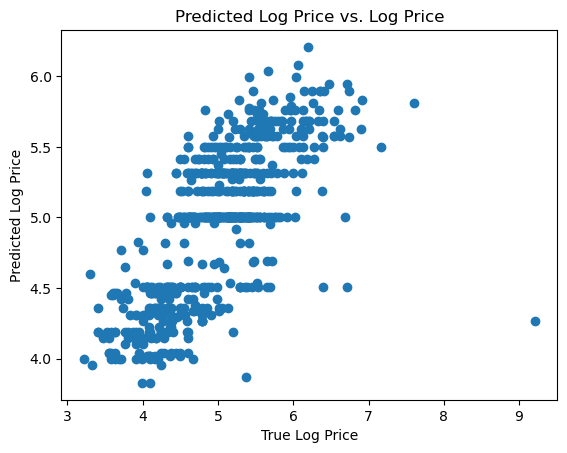

In [23]:
# View a simple scatter plot of the data (in the log domain)
plt.scatter(validation['log_price'], (lr.predict(X_val)))
plt.title('Predicted Log Price vs. Log Price')
plt.xlabel('True Log Price')
plt.ylabel('Predicted Log Price')
plt.show();

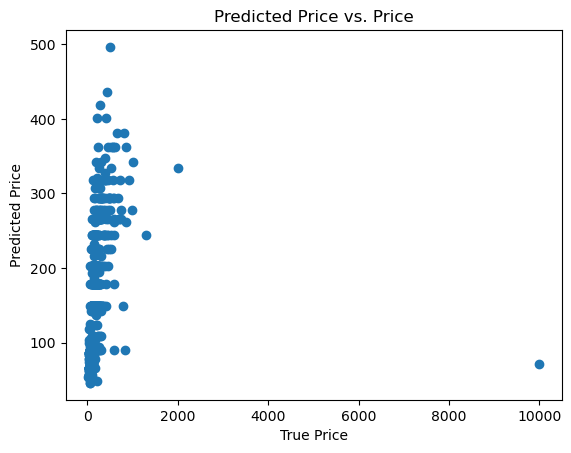

In [24]:
# View the same data but after exponentiating back to price
plt.scatter(validation['price'], (np.exp(lr.predict(X_val))))
plt.title('Predicted Price vs. Price')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.show();


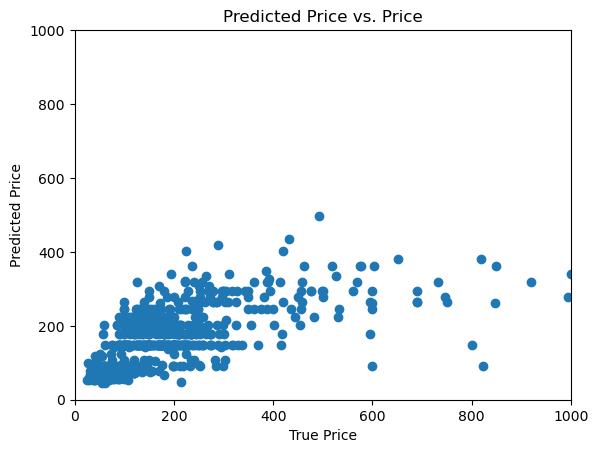

In [25]:
# Filter some of the outliers out-of-view to see how the rest of the data look
plt.scatter(validation['price'], (np.exp(lr.predict(X_val))))
plt.title('Predicted Price vs. Price')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.ylim(0, 1000)
plt.xlim(0, 1000)
plt.show();

#### OBSERVATIONS:
* Outliers are severely affecting the data, rendering a simple linear regression model almost useless
* When zooming in on the data, more linearity can be observed, but the data are still very scattered

# 5 - Automate Modeling Process
The function below is designed to take in the different feature sets, create whole training and validation dataframes, train/evaluate a list of models on those dataframes.  True versus predicted plots will be created in addition to dataframes will R2 and RMSE performance metrics.

In [26]:
'''
Create a function that will create training and validation datasets based on a list of
input columns against price and log_price data.  Do this only for the X data, y will 
always be the same.
'''

def data_X_maker(data_train, data_val, col_list, col_list_name):
    globals()[f'X_train_{col_list_name}']  = data_train[col_list]
    #print(f'X_train_{col_list_name}')
    
    globals()[f'X_val_{col_list_name}'] = data_val[col_list]
    #print(f'X_val_{col_list_name}')
    
    # Create common y datasets:
    globals()[f'y_train_{col_list_name}'] = data_train['price']
    #print(f'y_train_{col_list_name}')
    
    globals()[f'y_val_{col_list_name}'] = data_val['price']
    #print(f'y_val_{col_list_name}')
    
    globals()[f'y_train_log_{col_list_name}'] = data_train['log_price']
    #print(f'y_train_log_{col_list_name}')
    
    globals()[f'y_val_log_{col_list_name}'] = data_val['log_price']
    #print(f'y_val_log_{col_list_name}')
    
    globals()[f'data_list_{col_list_name}'] = [
        globals()[f'X_train_{col_list_name}'],
        globals()[f'X_val_{col_list_name}'],
        globals()[f'y_train_{col_list_name}'],
        globals()[f'y_val_{col_list_name}'],
        globals()[f'y_train_log_{col_list_name}'],
        globals()[f'y_val_log_{col_list_name}']
    ]
    print(f'data_list_{col_list_name}')
    
    return globals()[f'data_list_{col_list_name}']


'''
Create another function that will:
* Take in datasets that were previously created
* Fit a variety of models to them, training on both price and log price
* Produce plots of true versus predicted values for both price and log price for the training and validation data
'''
def model_maker(data_list, col_list_name, mod_list, plot_display = True):
    
    # Import data from a data list grabbing each component by index
    # X Data
    X_train_df = data_list[0]
    X_val_df = data_list[1]
    
    print(f'{X_train_df.shape}')
    
    # y datasets:
    y_train = data_list[2]
    y_val = data_list[3]
    
    y_train_log = data_list[4]
    y_val_log = data_list[5]

    # This is to change colors for each model so they're easier to identify
    color_code = 0
    
    # This is a dictionary which will house all metrics comupted in this loop
    modeling_dictionary = {'col_data': [], 
                 'model':[], 
                 'R2 training, price': [], 
                 'R2 training, log_price': [], 
                 'RMSE training, price': [],
                 'RMSE training, log_price': [],
                 'R2 validation, price': [],
                 'R2 validation, log_price': [],
                 'RMSE validation, price': [],
                 'RMSE validation, log_price': []                 
                }

    # Run the for loop to run all models in the input list on the data
    for model in mod_list:
        
        # **************  PRICE MODEL  ****************************************
        # Run Models on price
        model_inst = model
        model_inst.fit(X_train_df, y_train)
        
        # Predictions
        preds_price_train = model_inst.predict(X_train_df)
        preds_price_val = model_inst.predict(X_val_df)

        # Scores         
        r2_train_price = round(model_inst.score(X_train_df, y_train), 3)
        r2_val_price = round(r2_score(y_val, preds_price_val), 3)
        rmse_train_price = round(mean_squared_error(y_train, preds_price_train, squared = False), 3)
        rmse_val_price = round(mean_squared_error(y_val, preds_price_val, squared = False), 3)
        
        
        # ***************  LOG PRICE MODEL  ***************************************
        # Run models on log price
        model_inst_log = model
        model_inst_log.fit(X_train_df, y_train_log)
        
        # Predictions
        preds_log_price_train = np.exp(model_inst_log.predict(X_train_df))
        preds_log_price_val = np.exp(model_inst_log.predict(X_val_df))

        # Scores
        r2_train_log_price = round(r2_score(y_train, preds_log_price_train), 3)
        r2_val_log_price = round(r2_score(y_val, preds_log_price_val), 3)
        rmse_train_log_price = round(mean_squared_error(y_train, preds_log_price_train, squared = False), 3)
        rmse_val_log_price = round(mean_squared_error(y_val, preds_log_price_val, squared = False), 3)
        
        # Append values to dictionary:
        modeling_dictionary['col_data'].append(col_list_name)
        modeling_dictionary['model'].append(f'{model}'), 
        modeling_dictionary['R2 training, price'].append(r2_train_price) 
        modeling_dictionary['R2 training, log_price'].append(r2_train_log_price) 
        modeling_dictionary['RMSE training, price'].append(rmse_train_price)
        modeling_dictionary['RMSE training, log_price'].append(rmse_train_log_price)
        modeling_dictionary['R2 validation, price'].append(r2_val_price)
        modeling_dictionary['R2 validation, log_price'].append(r2_val_log_price)
        modeling_dictionary['RMSE validation, price'].append(rmse_val_price)
        modeling_dictionary['RMSE validation, log_price'].append(rmse_val_log_price)

        # Print the metrics so they can be viewed
#         print('\n')
#         print('=' * 50)       
#         print(f'R2 training, price: {r2_train_price}')
#         print(f'R2 training, log_price: {r2_train_log_price}')
        
#         print(f'RMSE training, price: {rmse_train_price}')
#         print(f'RMSE training, log_price: {rmse_train_log_price}\n')
        
#         #print('\n')
#         print(f'R2 validation, price: {r2_val_price}')
#         print(f'R2 validation, log_price: {r2_val_log_price}')
        
#         print(f'RMSE validation, price: {rmse_val_price}')
#         print(f'RMSE validation, log_price: {rmse_val_log_price}')      
#        print('=' * 50)
        
        if plot_display == True:
            plt.figure(figsize = (10, 8))
            plt.subplots_adjust(hspace=0.7)

            plt.subplot(2, 2, 1)
            plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'\nR2: {r2_train_price} | RMSE: {rmse_train_price}")
            plt.scatter(y_train, preds_price_train, color = f'C{color_code}')
            plt.xlabel('True Prices')
            plt.ylabel('Predicted Prices')

            plt.subplot(2, 2, 2)
            plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'\nR2: {r2_train_log_price} | RMSE: {rmse_train_log_price}")
            plt.scatter(y_train, preds_log_price_train, color = f'C{color_code}')
            plt.xlabel('True Prices')
            plt.ylabel('Predicted Prices')

            plt.subplot(2, 2, 3)
            plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'\nR2: {r2_val_price} | RMSE: {rmse_val_price}")
            plt.scatter(y_val, preds_price_val, color = f'C{color_code}')
            plt.xlabel('True Prices')        
            plt.ylabel('Predicted Prices')

            plt.subplot(2, 2, 4)
            plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'\nR2: {r2_val_log_price} | RMSE: {rmse_val_log_price}")
            plt.scatter(y_val, preds_log_price_val, color = f'C{color_code}')
            plt.xlabel('True Prices')
            plt.ylabel('Predicted Prices')

            plt.show()
        
        # Up the color code for the next model
        color_code += 1
    
    # Store the metrics dataframe to a global variable for reference later
    globals()[f'eval_metrics_{col_list_name}'] = pd.DataFrame(modeling_dictionary)
    
    '''
    The follwoing formatting code was inspired by the following sources:
    * My project 3 - https://git.generalassemb.ly/drossetti/project-3/blob/main/code/4-Modeling-Round-2.ipynb
    * https://www.geeksforgeeks.org/highlight-the-maximum-value-in-each-column-in-pandas/
    * https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.highlight_max.html
    * Assking ChatGPT:  "i need an example of using the subset argument in a pandas dataframe formatted with style.highlight_max"
    * https://medium.com/gustavorsantos/how-to-highlight-max-min-or-nulls-with-pandas-f2df5bf4ccf9
    '''

    return globals()[f'eval_metrics_{col_list_name}']

# .style\
# .highlight_max(subset = ['R2 training, price', 'R2 training, log_price', 'R2 validation, price', 'R2 validation, log_price'], color = 'darkred')\
# .highlight_min(subset = ['RMSE training, price', 'RMSE training, log_price', 'RMSE validation, price', 'RMSE validation, log_price'], color = 'blue')

# 6 - Modeling: All Feature Sets
The five previously created feature sets will now be input into the above function.

Each will be used to train/evaluate seven regressor models, and each model will be trained/evaluted with price and log_price as the targets

In [27]:
# Make a list of models to run!
list_of_models = [LinearRegression(),
                  RandomForestRegressor(random_state=42), 
                  BaggingRegressor(random_state=42),
                  GradientBoostingRegressor(random_state=42),
                  ExtraTreesRegressor(random_state=42),
                  AdaBoostRegressor(random_state=42),
                  DecisionTreeRegressor(random_state=42)]

data_list_top_5_ft_no_mc
(2781, 5)


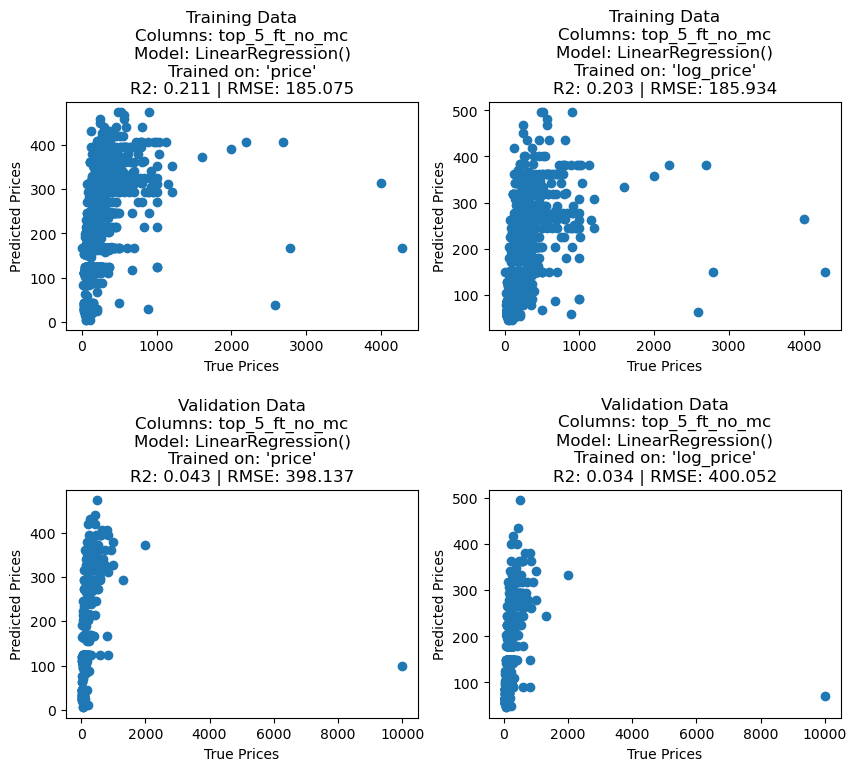

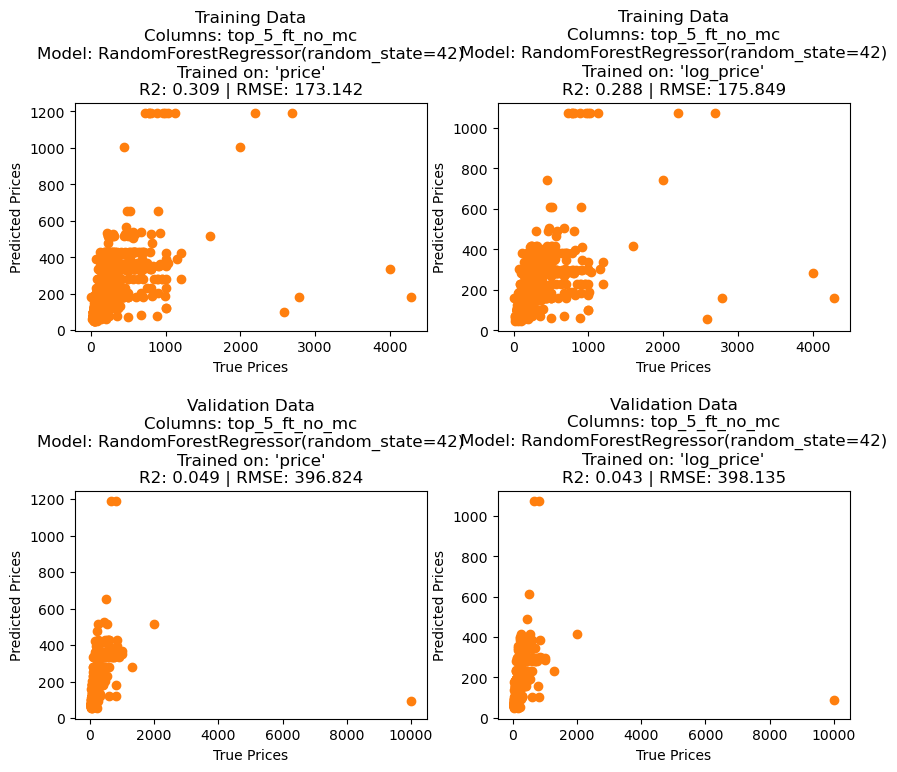

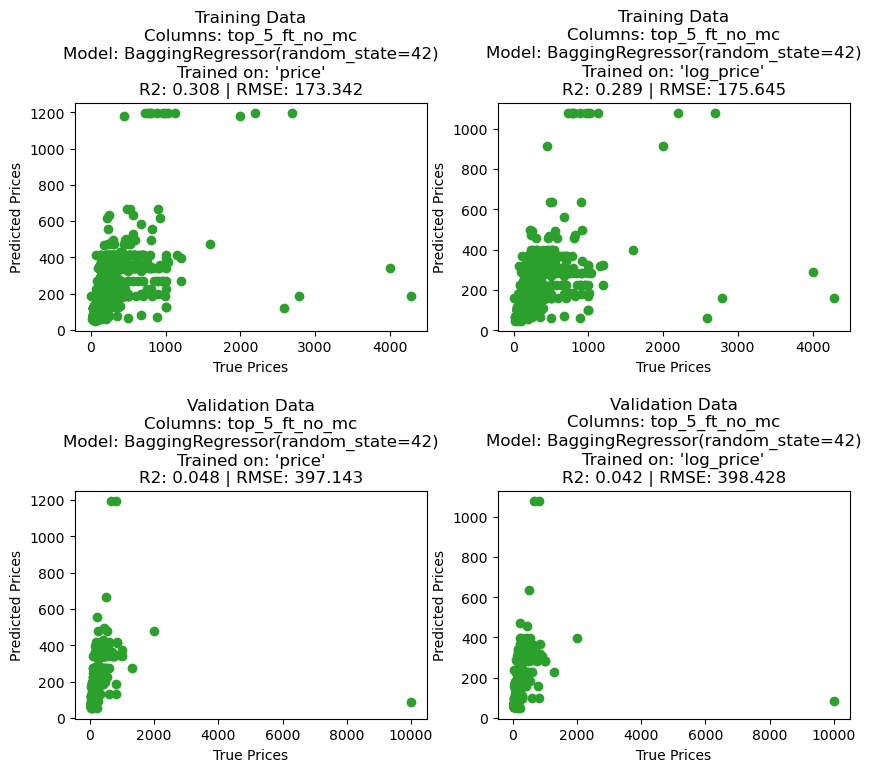

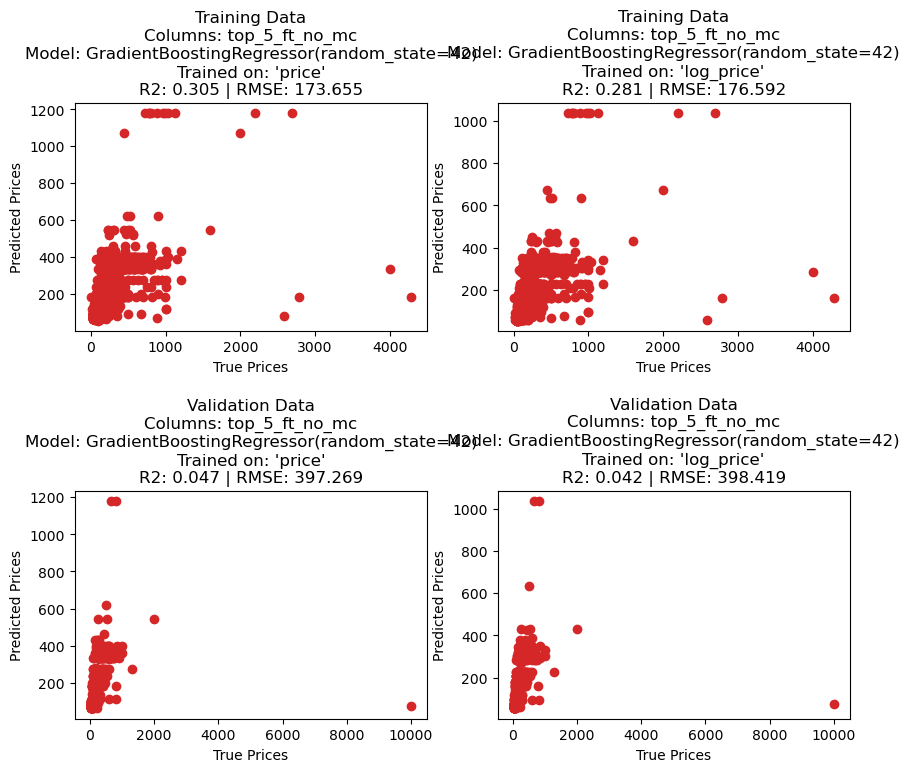

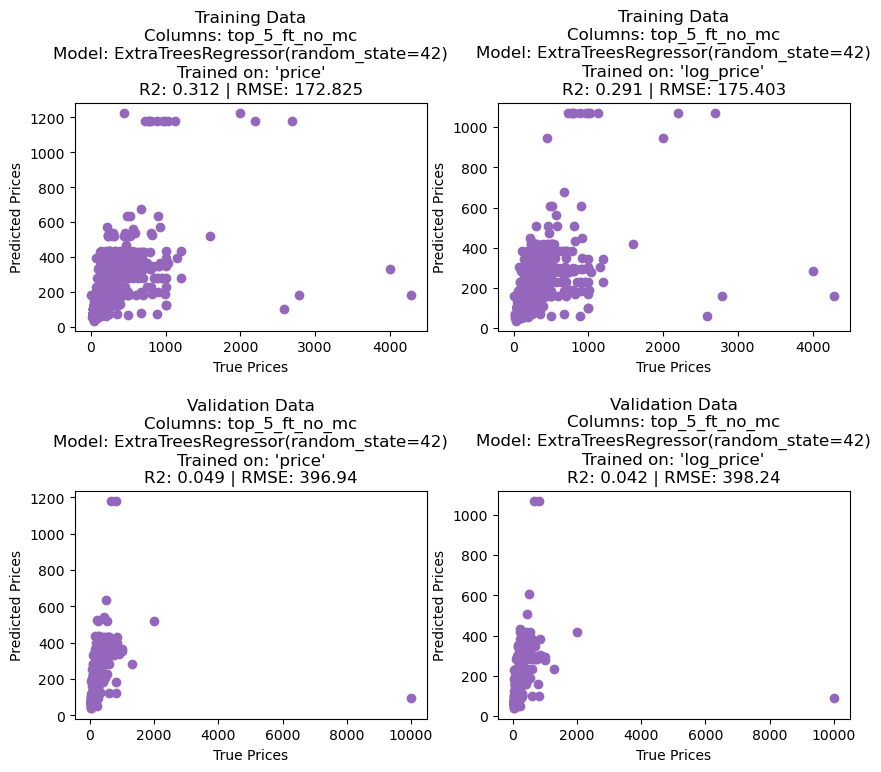

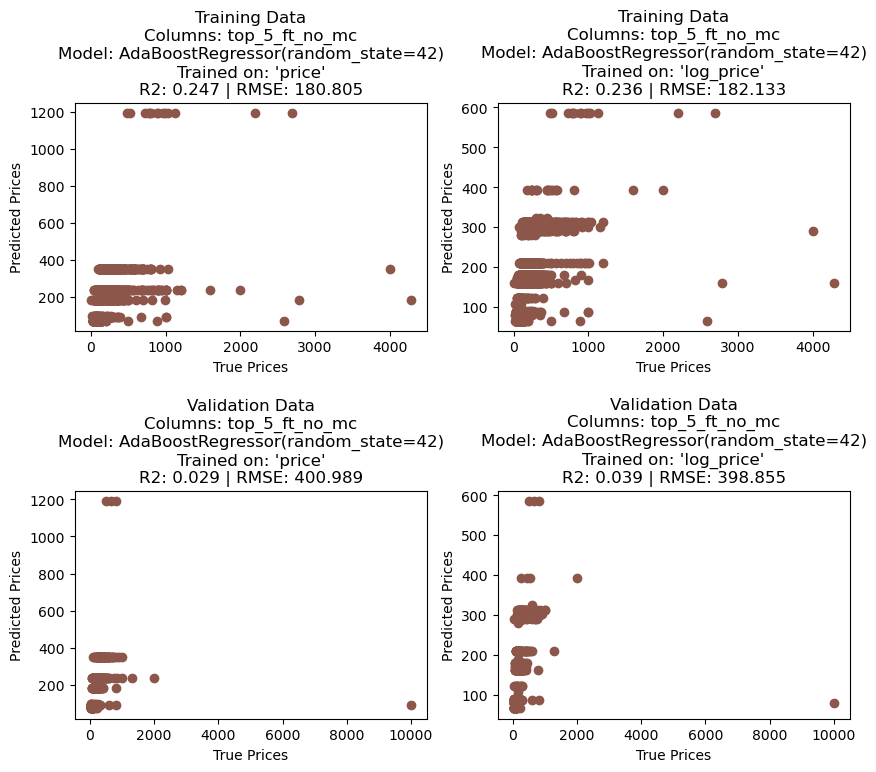

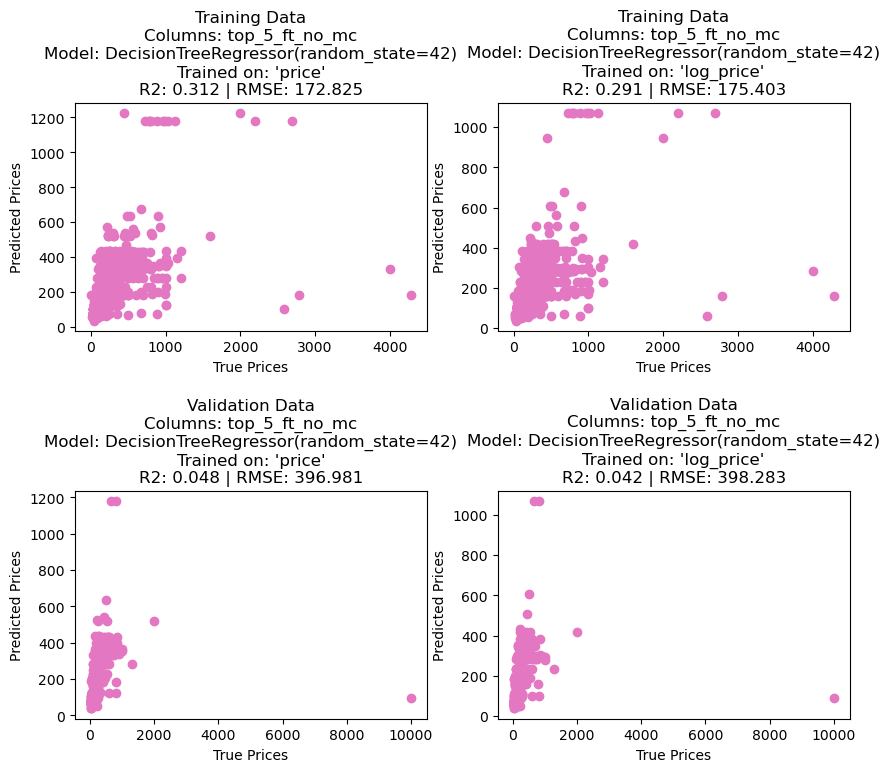

data_list_top_10_ft_no_mc
(2781, 10)


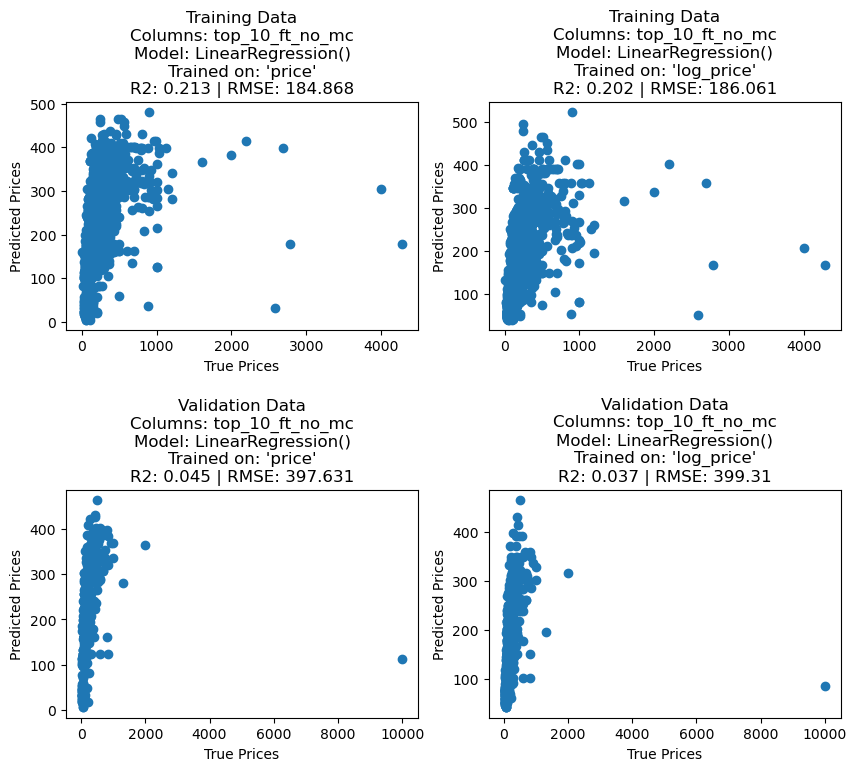

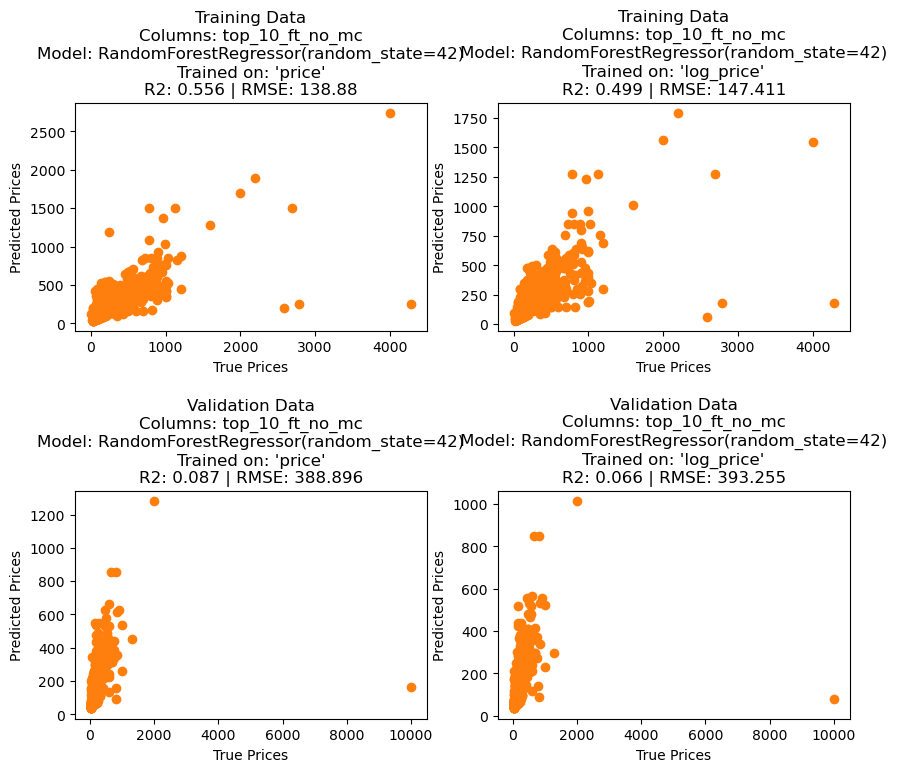

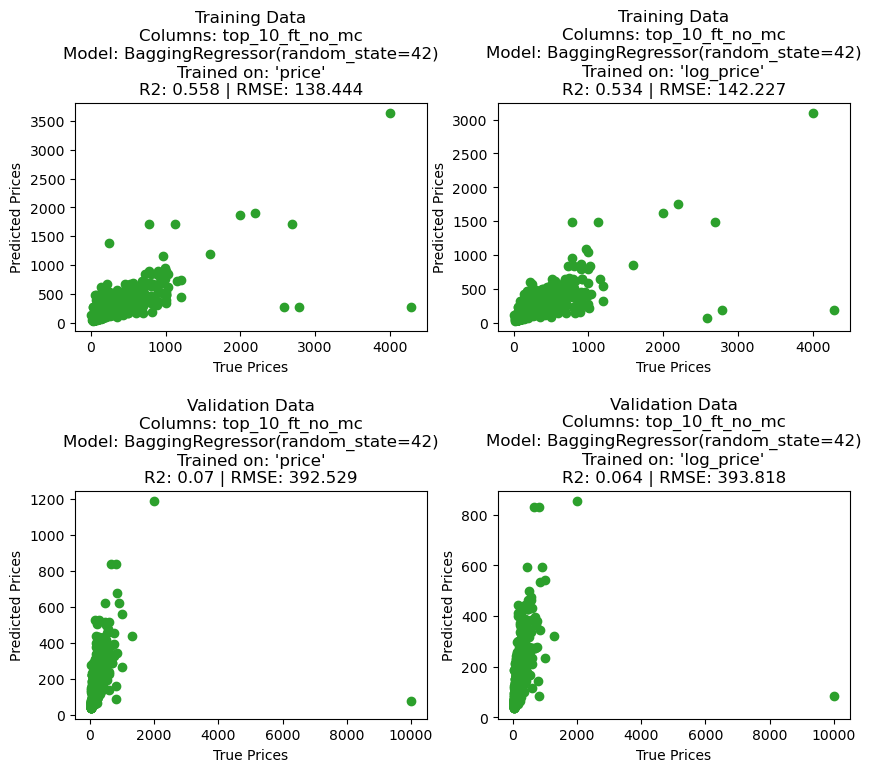

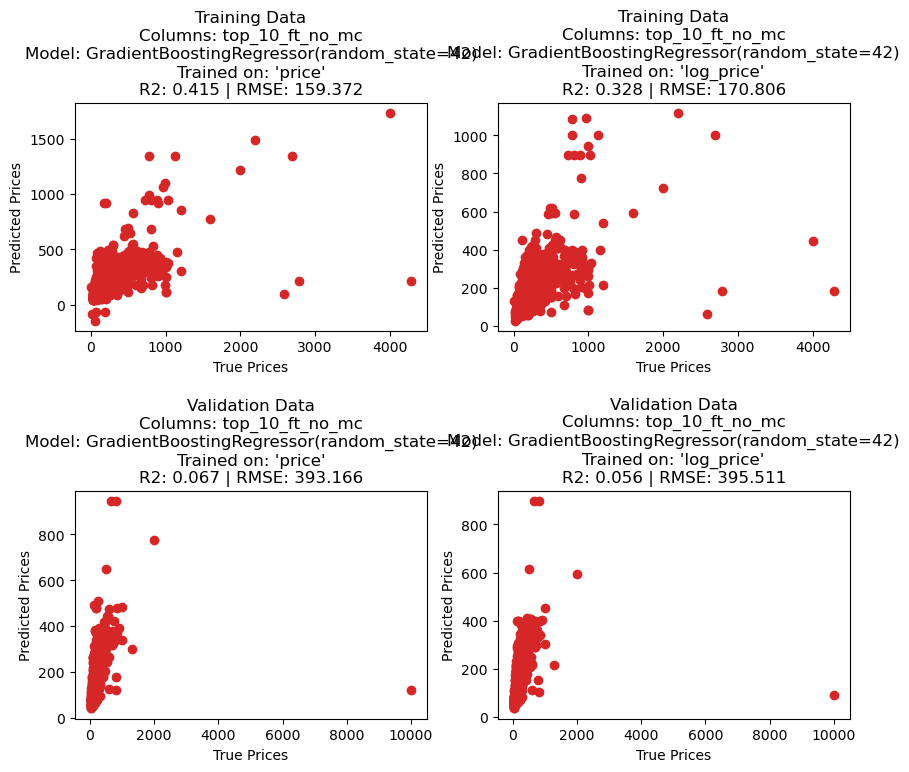

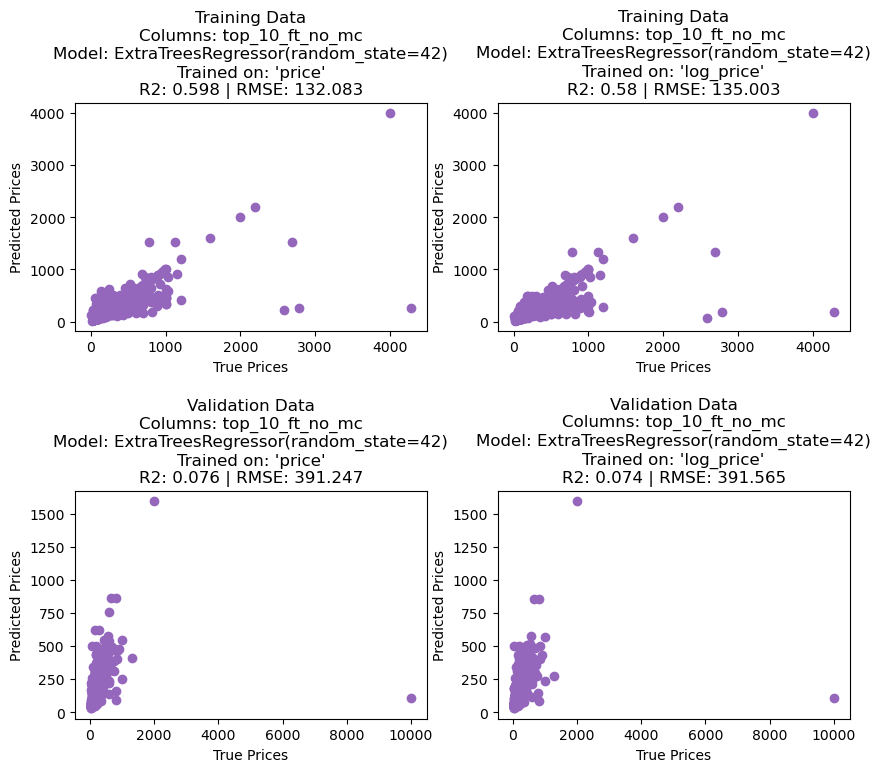

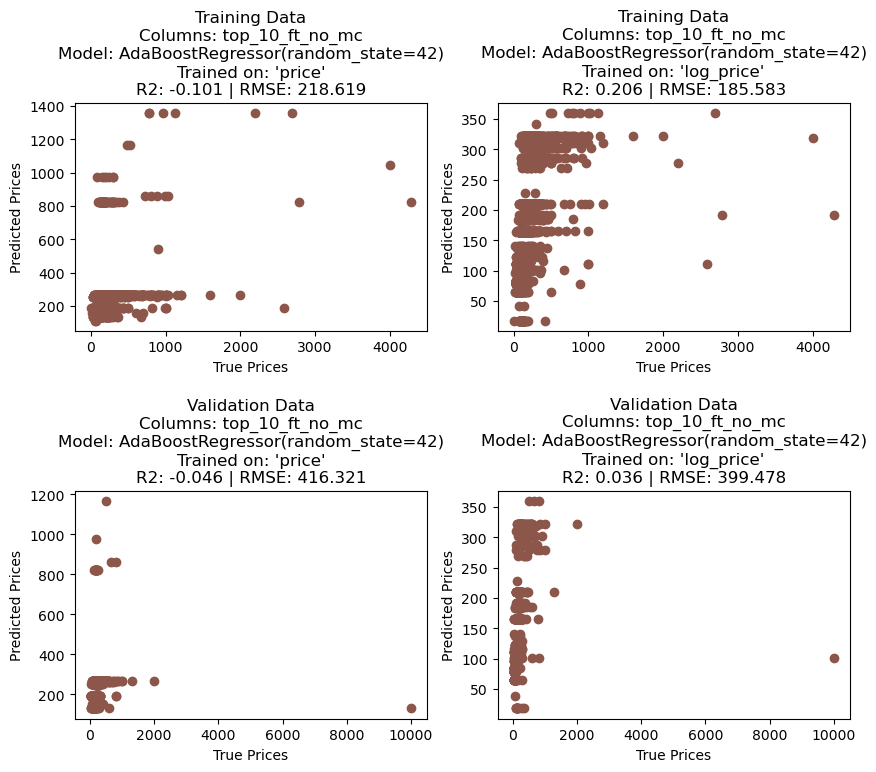

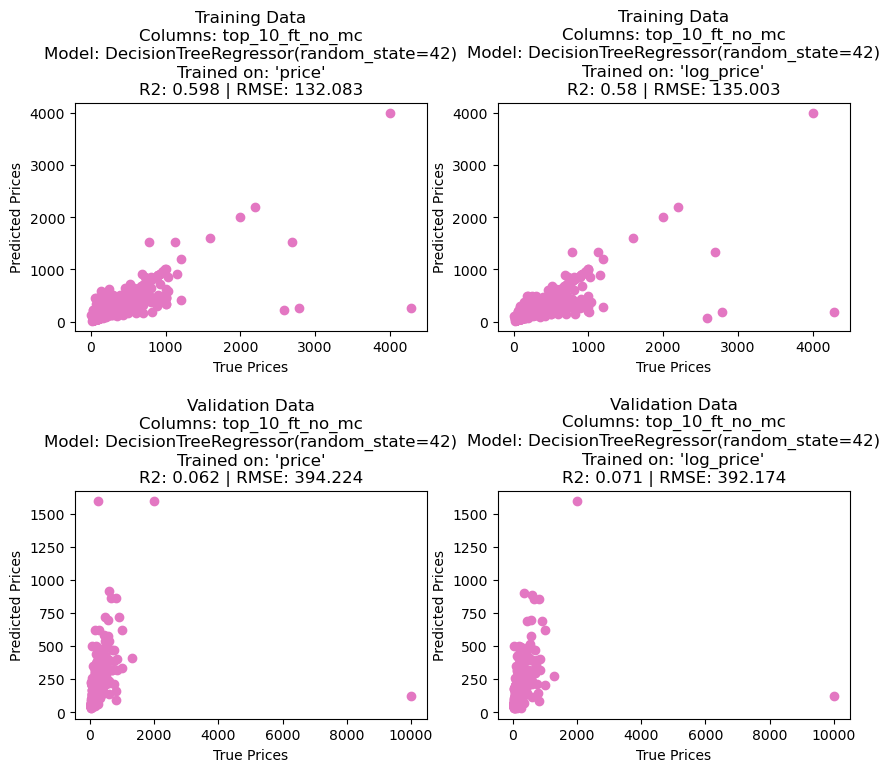

data_list_top_30_ft_no_mc
(2781, 30)


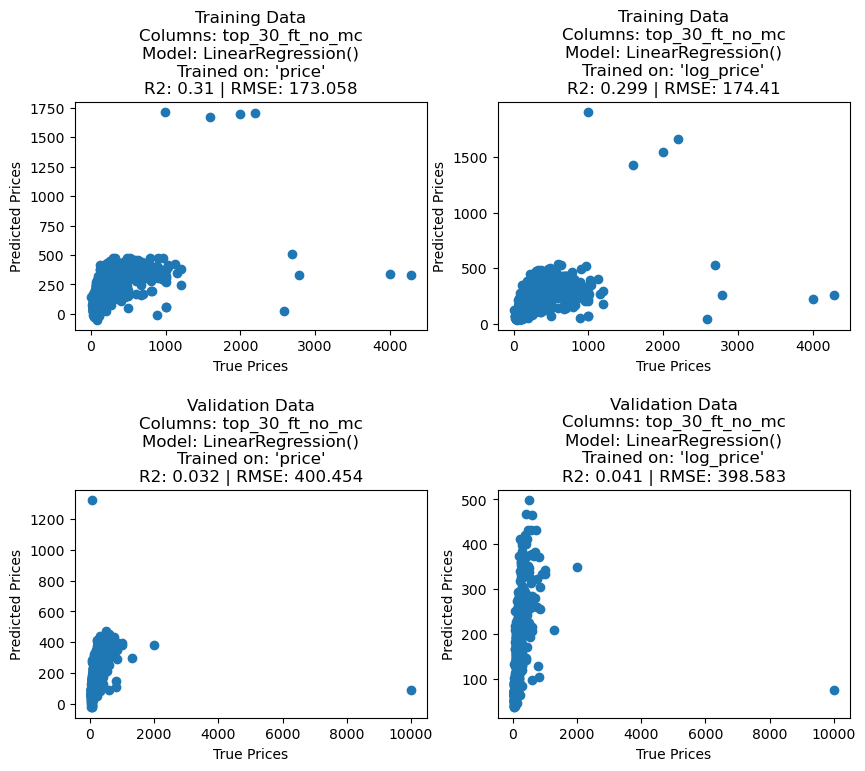

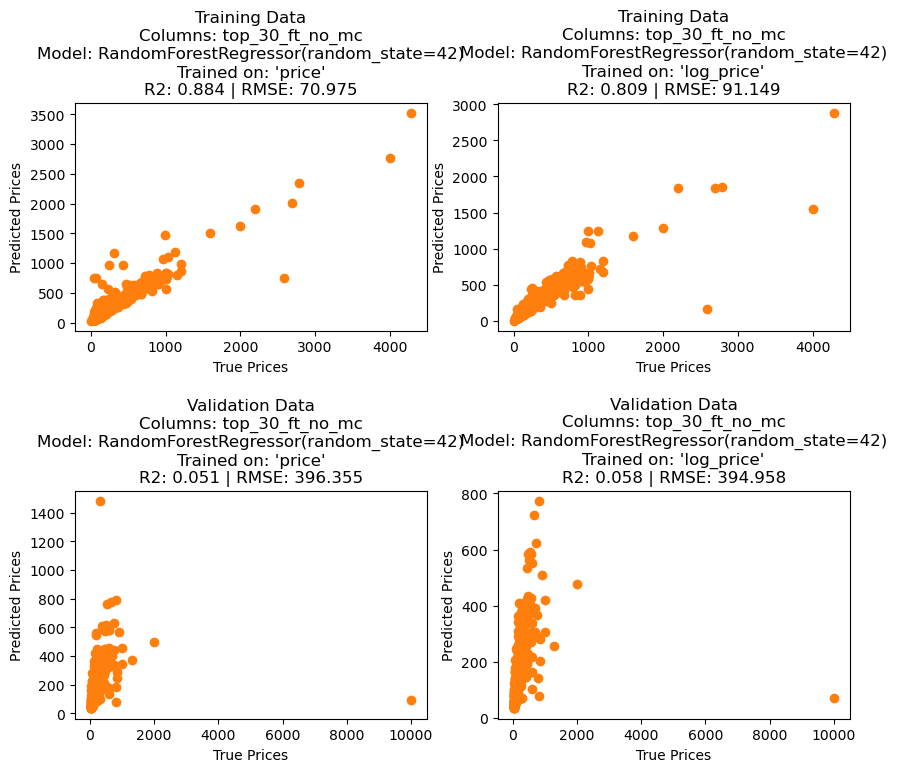

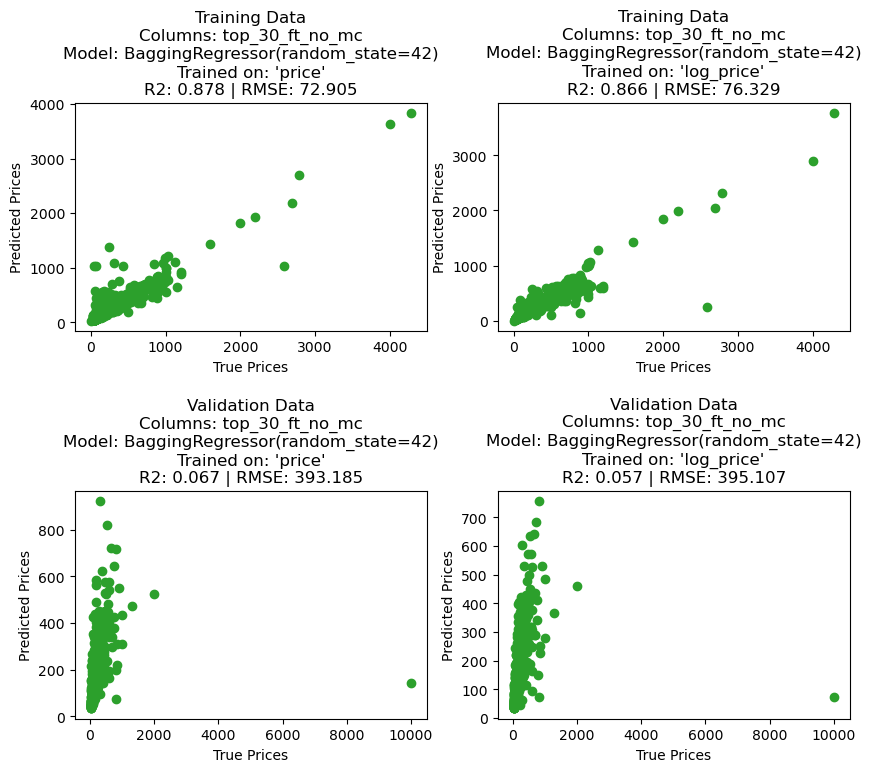

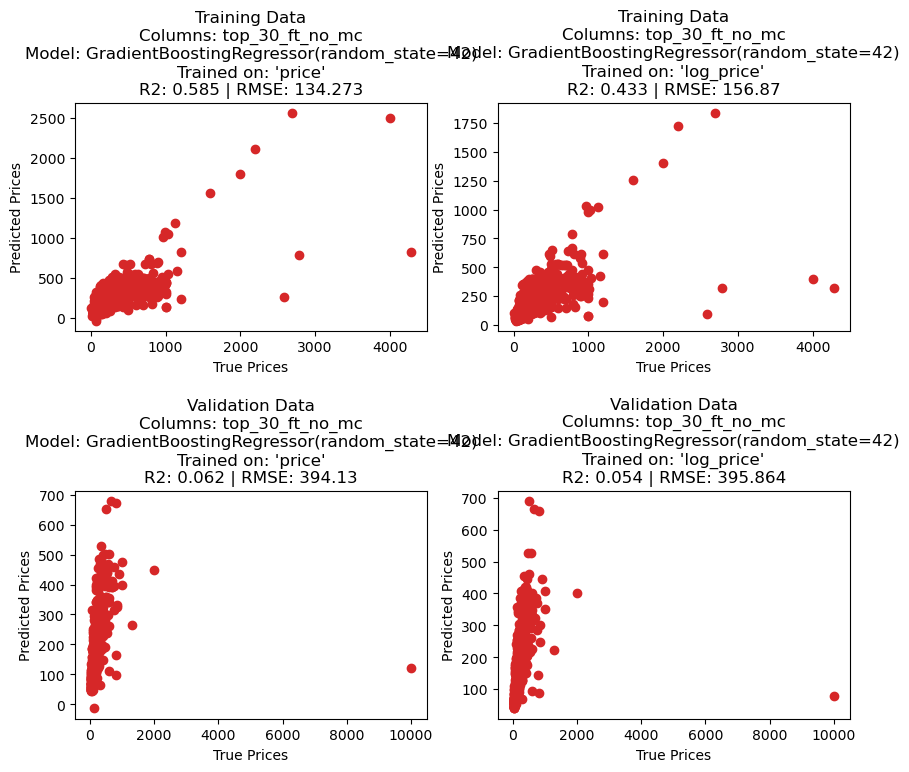

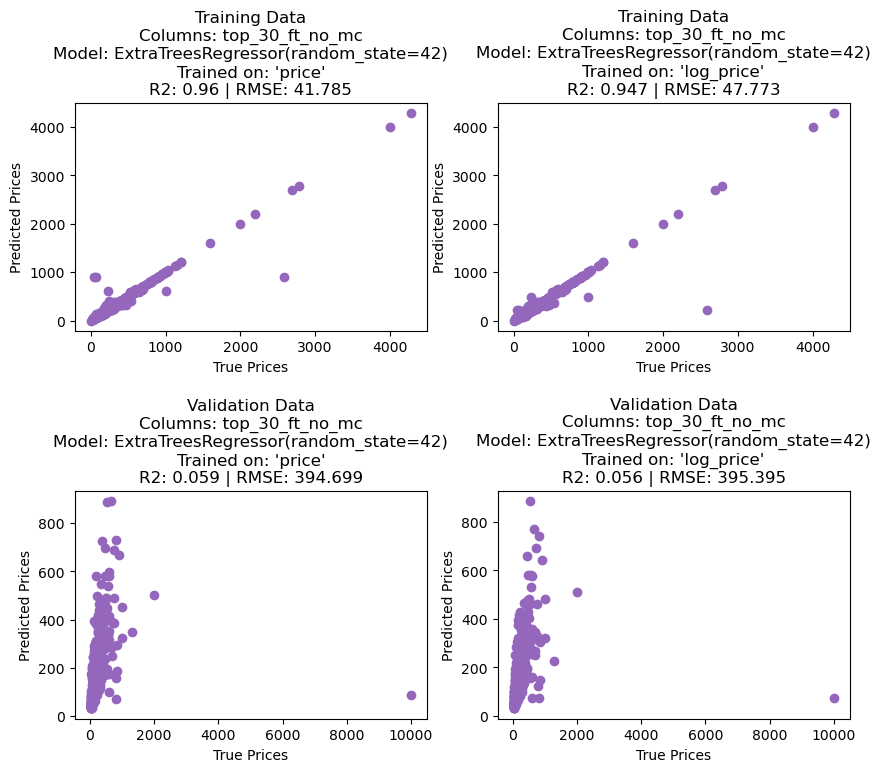

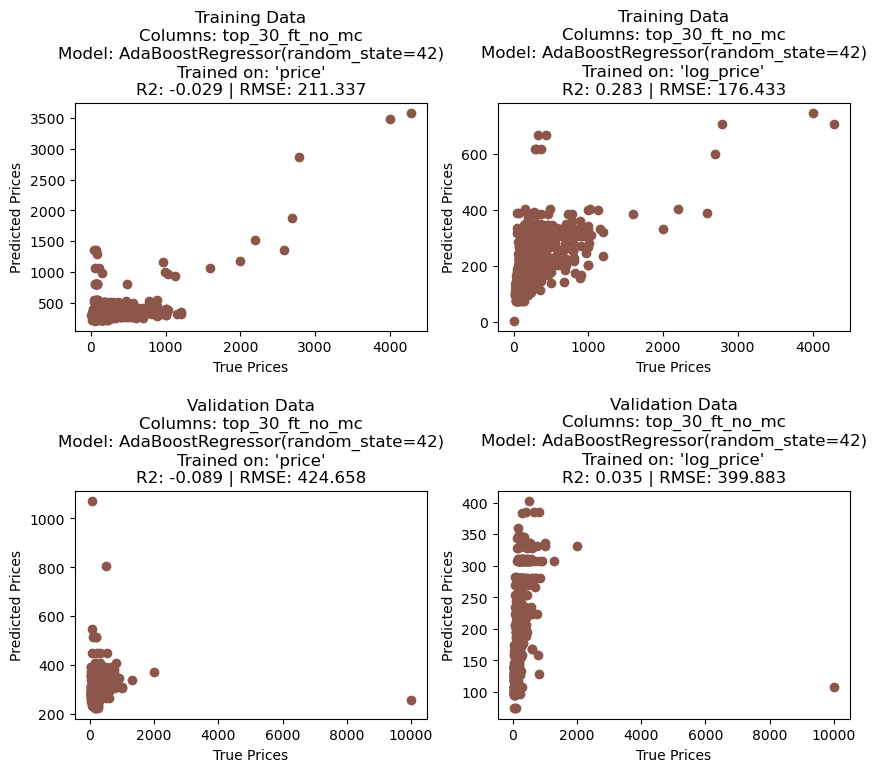

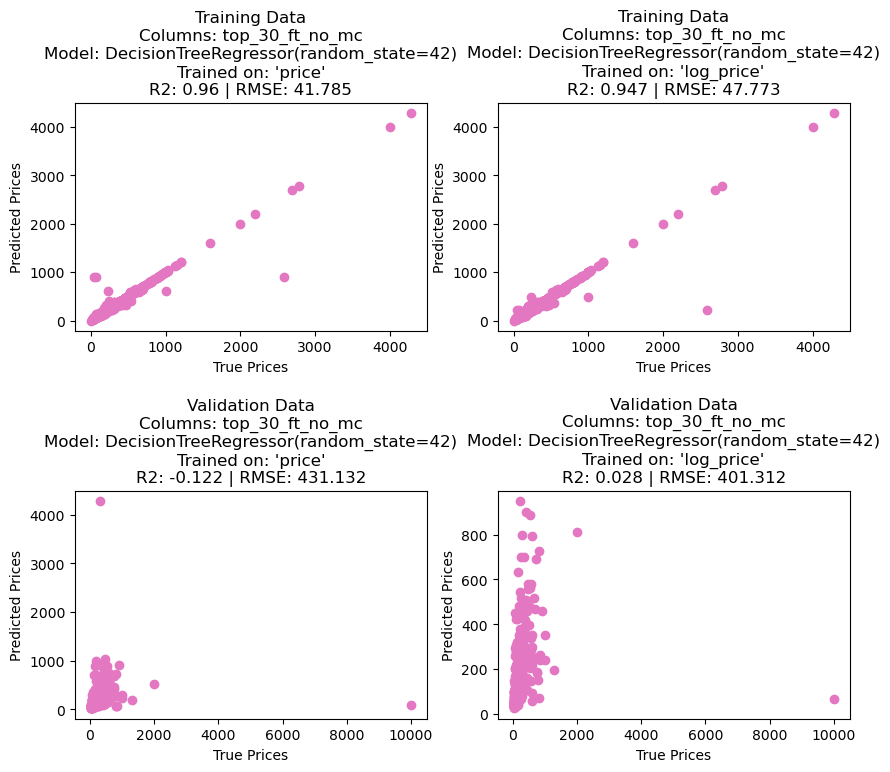

data_list_top_50_ft_no_mc
(2781, 50)


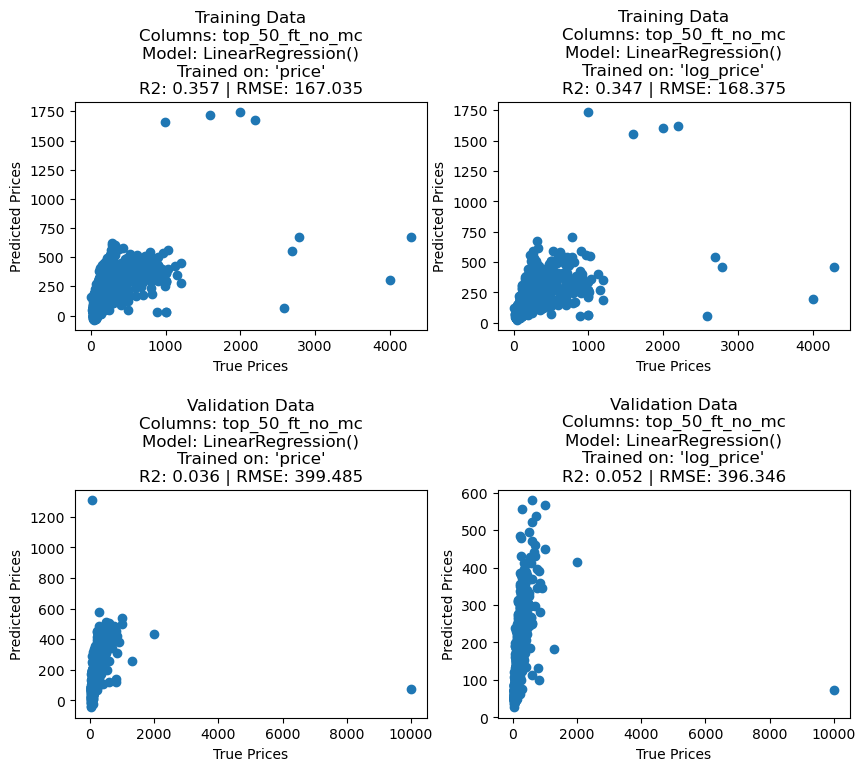

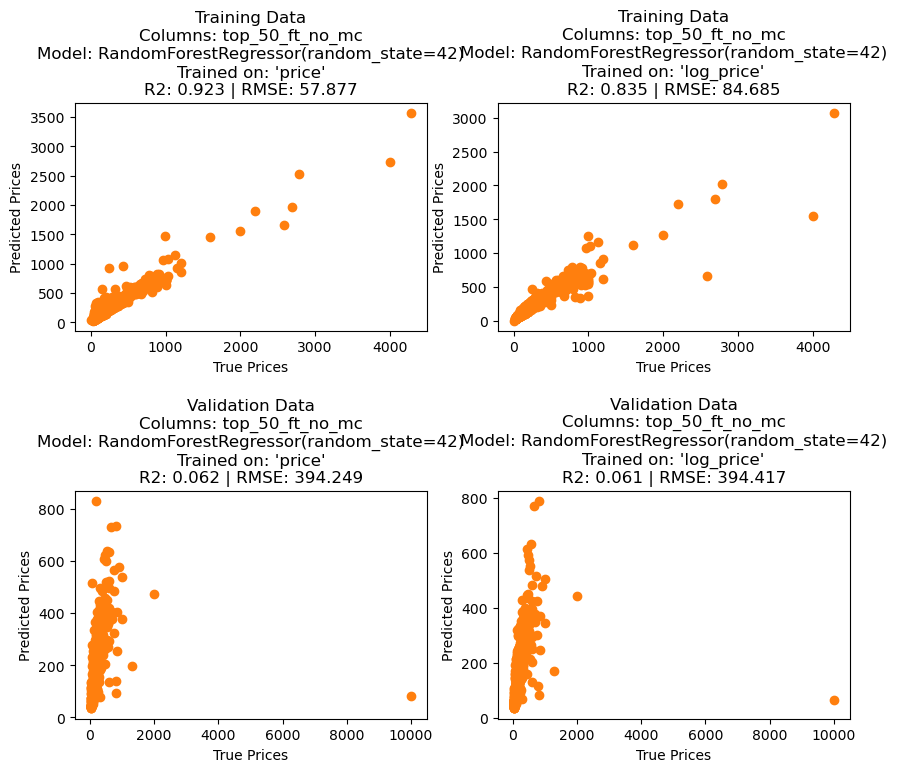

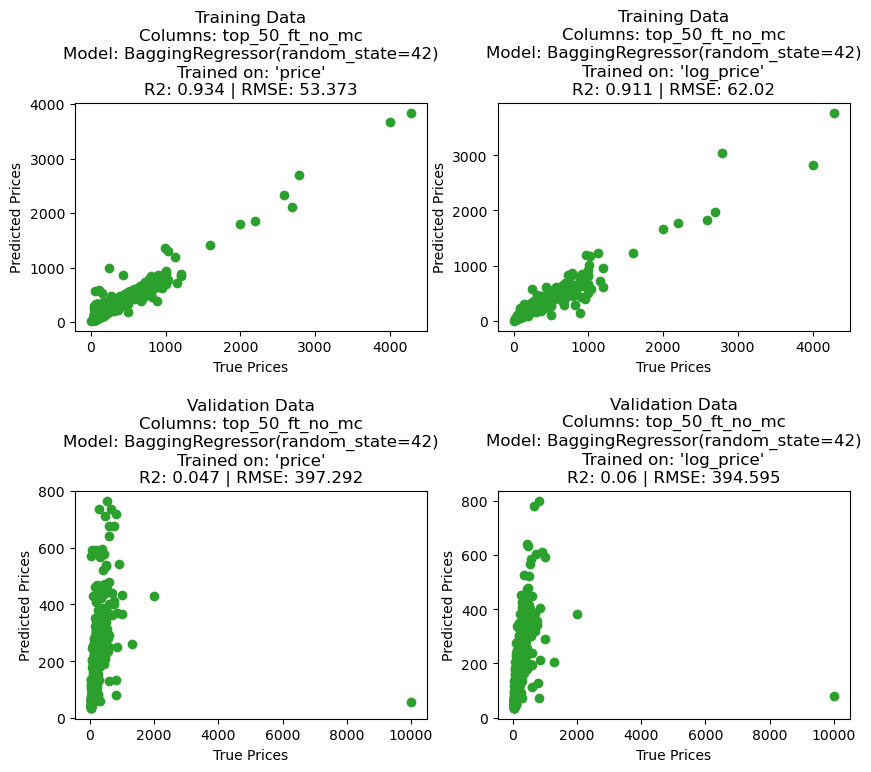

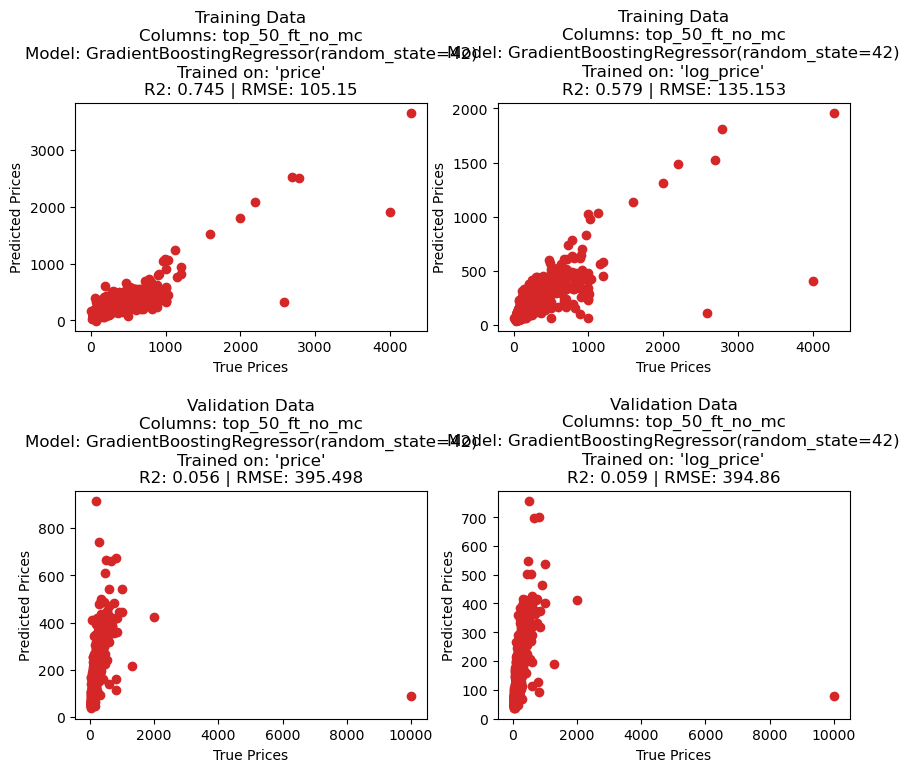

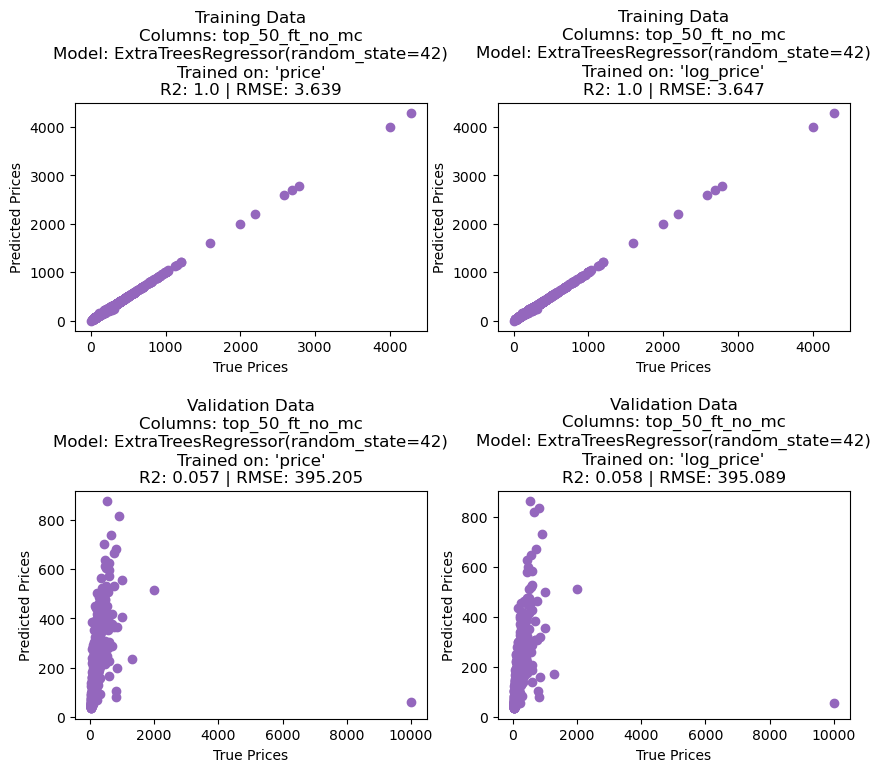

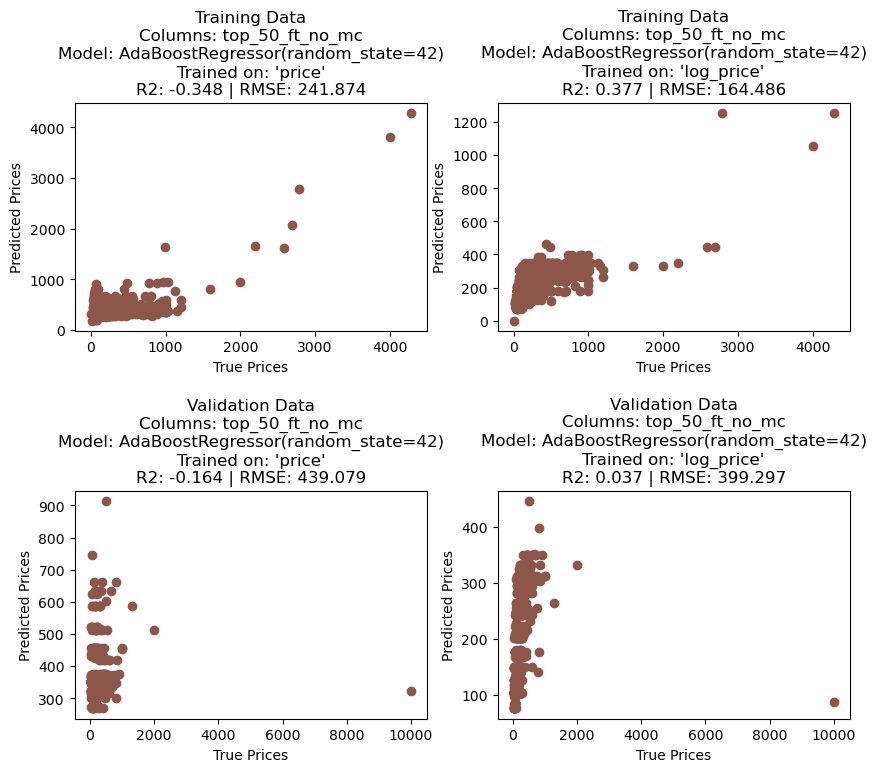

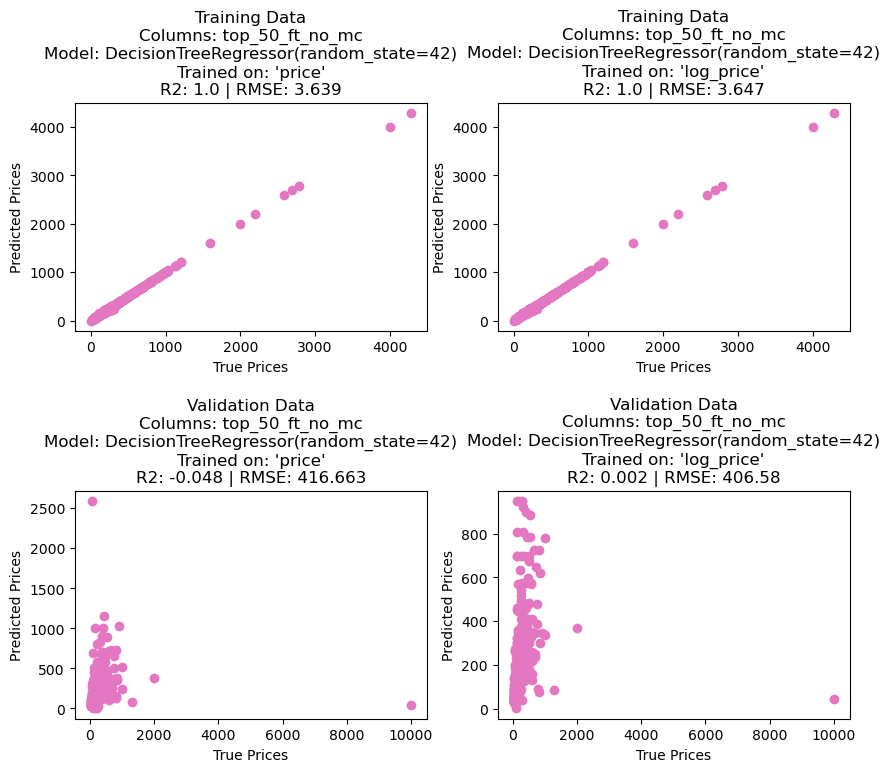

data_list_top_100_ft_no_mc
(2781, 100)


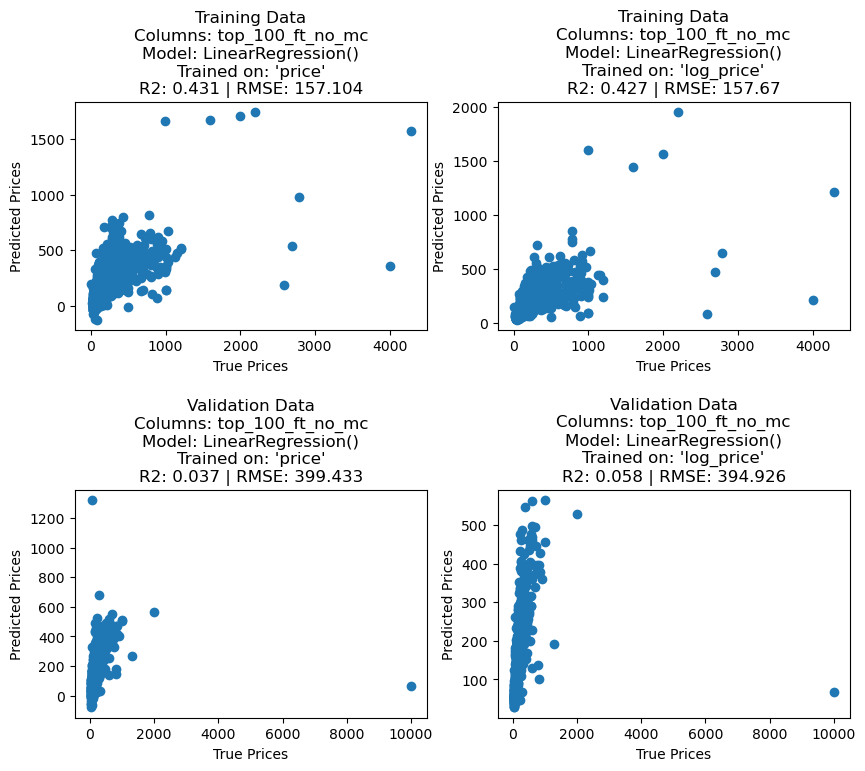

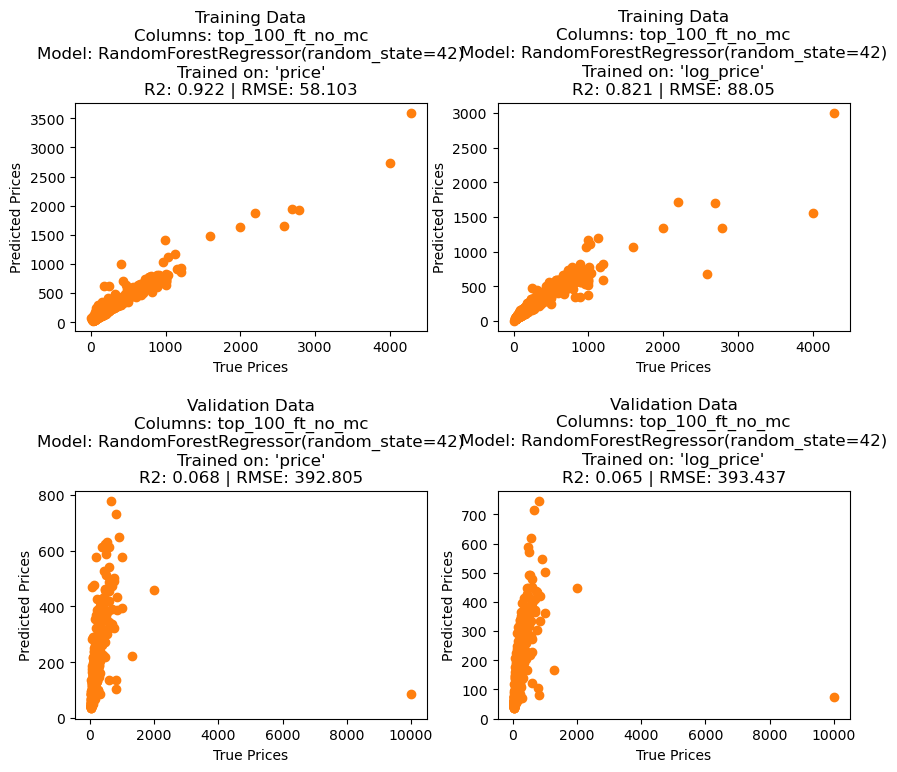

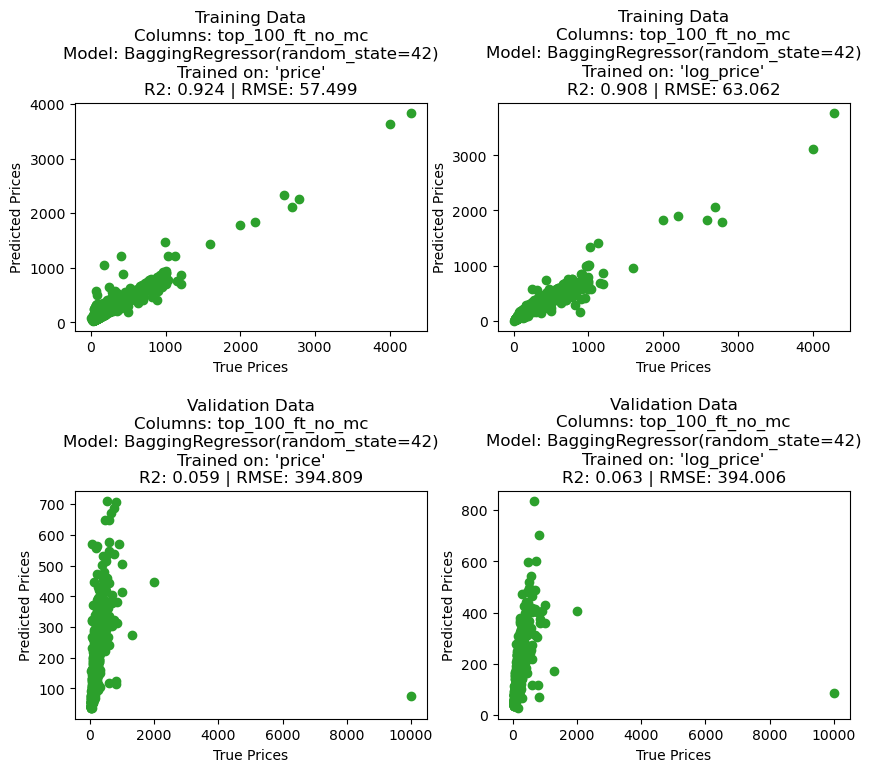

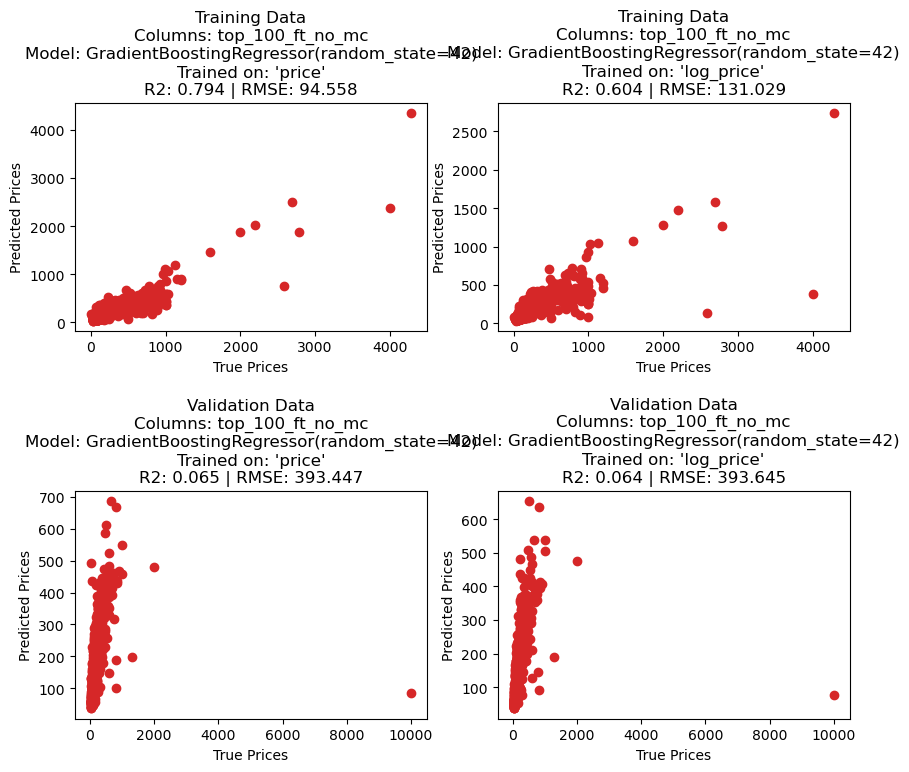

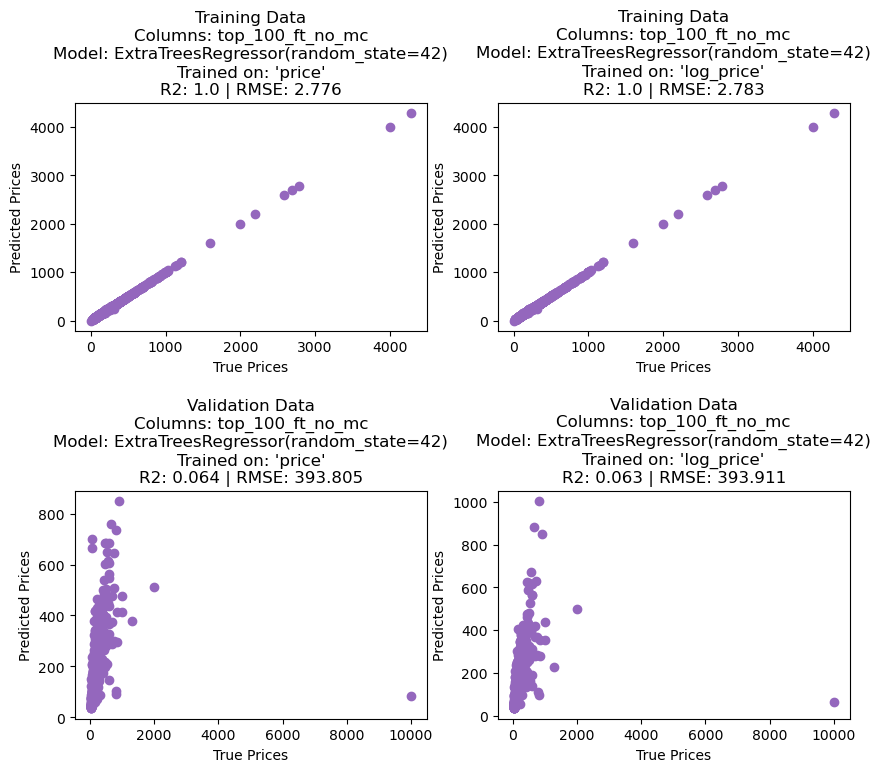

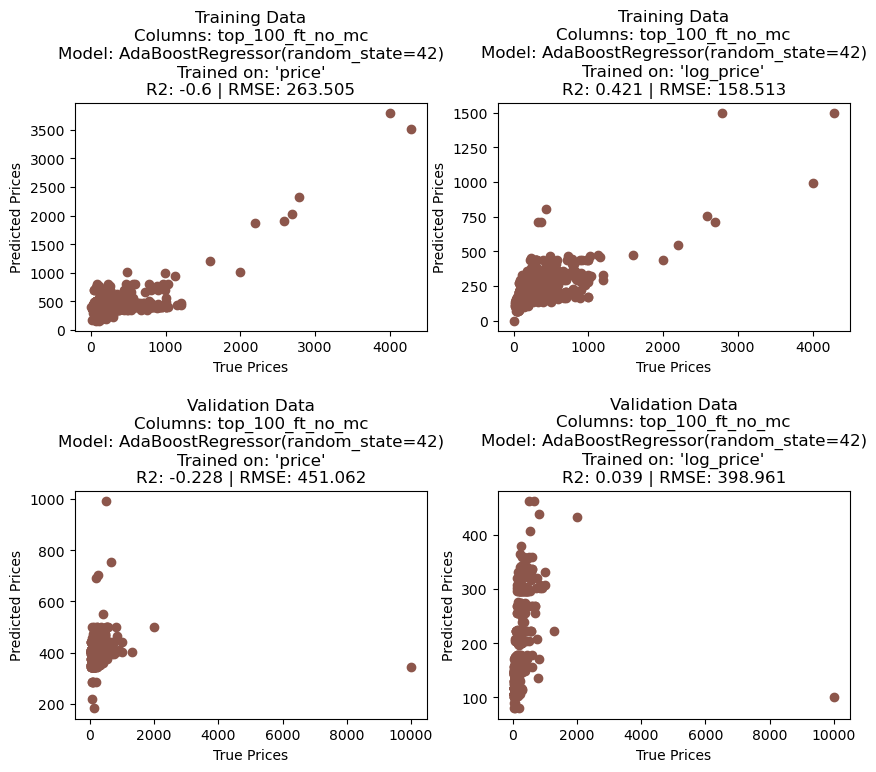

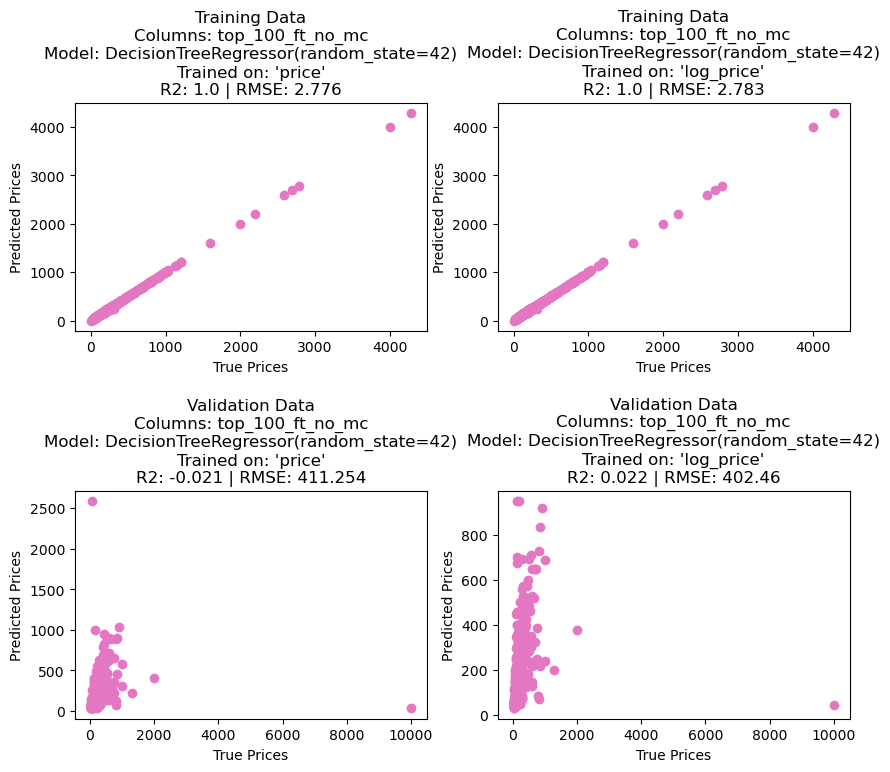

In [28]:
# Run the data maker function inside of the model maker function
#  Write a loop that will loop through datasets using columns in the column lists created previously

column_lists = [
    [top_5_ft_no_mc, 'top_5_ft_no_mc'],
    [top_10_ft_no_mc, 'top_10_ft_no_mc'],
    [top_30_ft_no_mc, 'top_30_ft_no_mc'],
    [top_50_ft_no_mc, 'top_50_ft_no_mc'],
    [top_100_ft_no_mc, 'top_100_ft_no_mc'],
]

# Create an empty dataframe to store evaluation results
model_eval_metrics = pd.DataFrame(columns=['col_data', 'model', 'R2 training, price', 'R2 training, log_price',
       'RMSE training, price', 'RMSE training, log_price',
       'R2 validation, price', 'R2 validation, log_price',
       'RMSE validation, price', 'RMSE validation, log_price'])

for array in column_lists:
    df_array = model_maker(data_X_maker(lstn, validation, array[0], f'{array[1]}'), 
            f'{array[1]}', 
            list_of_models)
    
    # Add the new dataframe to the larger dataframe
    model_eval_metrics = pd.concat([model_eval_metrics, df_array])
    
model_eval_metrics.reset_index(drop=True).style\
.highlight_max(subset = ['R2 training, price', 'R2 training, log_price', 'R2 validation, price', 'R2 validation, log_price'], color = 'darkred')\
.highlight_min(subset = ['RMSE training, price', 'RMSE training, log_price', 'RMSE validation, price', 'RMSE validation, log_price'], color = 'blue')   

In [29]:
# Check validation RMSE ranges for price target
print(model_eval_metrics['RMSE validation, price'].min(), model_eval_metrics['RMSE validation, price'].max())

# Check validation RMSE ranges for log price target
print(model_eval_metrics['RMSE validation, log_price'].min(), model_eval_metrics['RMSE validation, log_price'].max())

388.896 451.062
391.565 406.58


##  6.1 - Observations:
* All models are prone to various levels of overfitting
* Despite the levels of overfitting, R-squared and RMSE values on the validation data are quite poor
    * RMSE values on the validaiton data range between \\$388.81 and $472.69 across both the price and log price targets
    * R2 values never get above 0.087, which is still only slightly better than the null model
* Models with price as the target seemed to produce the best model as compared to models with log_price as the target.  However, the models with log price as the target have a much narrower range of RMSE values raning between \\$391.72 and \\$405.40 as compared to \\$388.81 and \\$472.69 for price
* The best performing model was a default parameter random forrest regressor with an RMSE of \\$388.81

Generally speaking, these models are very poor, and there are some important features missing to properly characterize outliers.  The next sections will seek to showcase this by:
* Performing model optimization with gridsearching
* limiting the input dataset to exclude outliers (higher-priced listings)

#  7 - Optimize the Best Model and Evaluate

data_list_best_cols_no_mc
(2409, 16)


R2 training, price: 0.51
R2 training, log_price: 0.488
RMSE training, price: 48.291
RMSE training, log_price: 49.346

R2 validation, price: 0.496
R2 validation, log_price: 0.454
RMSE validation, price: 49.474
RMSE validation, log_price: 51.522


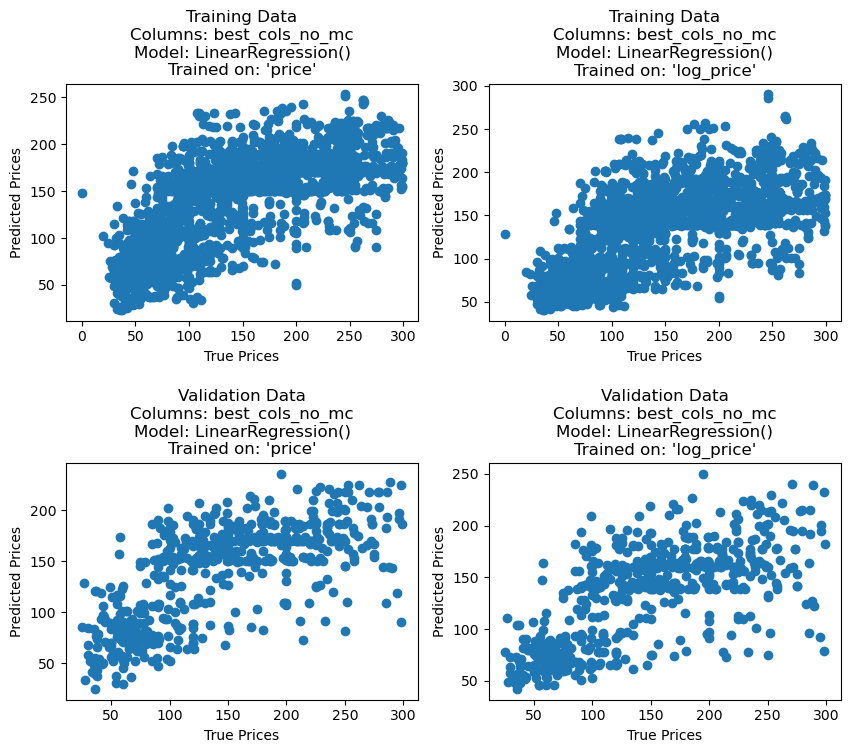



R2 training, price: 0.923
R2 training, log_price: 0.914
RMSE training, price: 19.195
RMSE training, log_price: 20.201

R2 validation, price: 0.582
R2 validation, log_price: 0.576
RMSE validation, price: 45.052
RMSE validation, log_price: 45.377


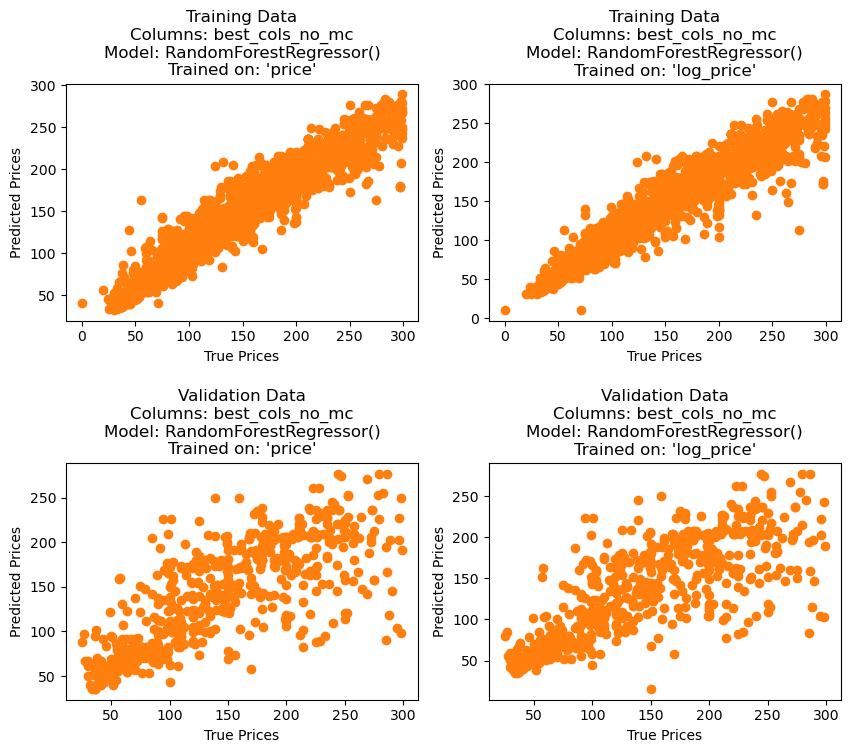



R2 training, price: 0.906
R2 training, log_price: 0.898
RMSE training, price: 21.198
RMSE training, log_price: 22.0

R2 validation, price: 0.569
R2 validation, log_price: 0.579
RMSE validation, price: 45.769
RMSE validation, log_price: 45.244


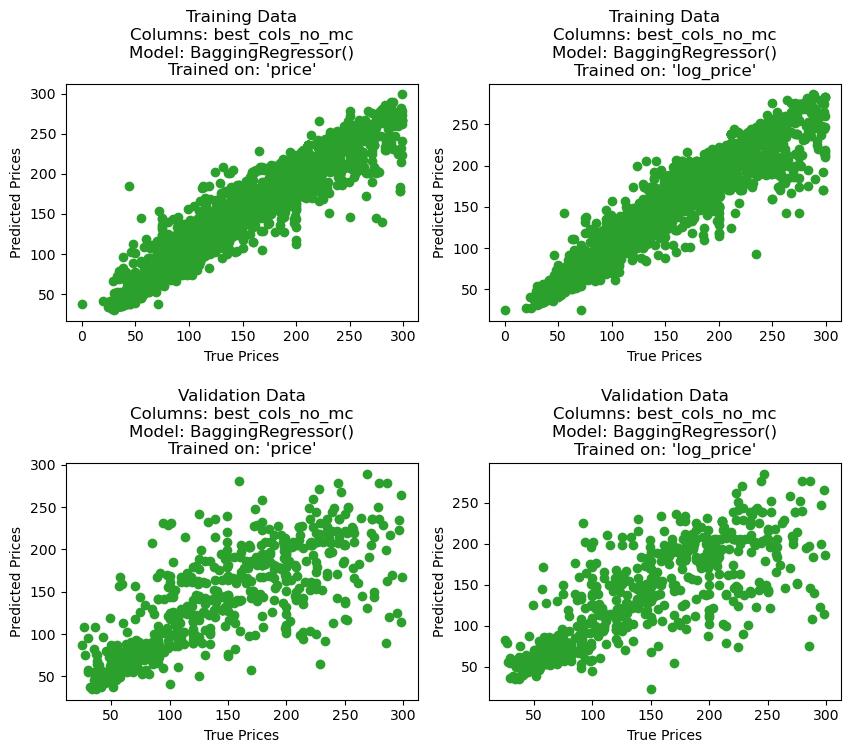



R2 training, price: 0.668
R2 training, log_price: 0.642
RMSE training, price: 39.757
RMSE training, log_price: 41.293

R2 validation, price: 0.594
R2 validation, log_price: 0.555
RMSE validation, price: 44.422
RMSE validation, log_price: 46.494


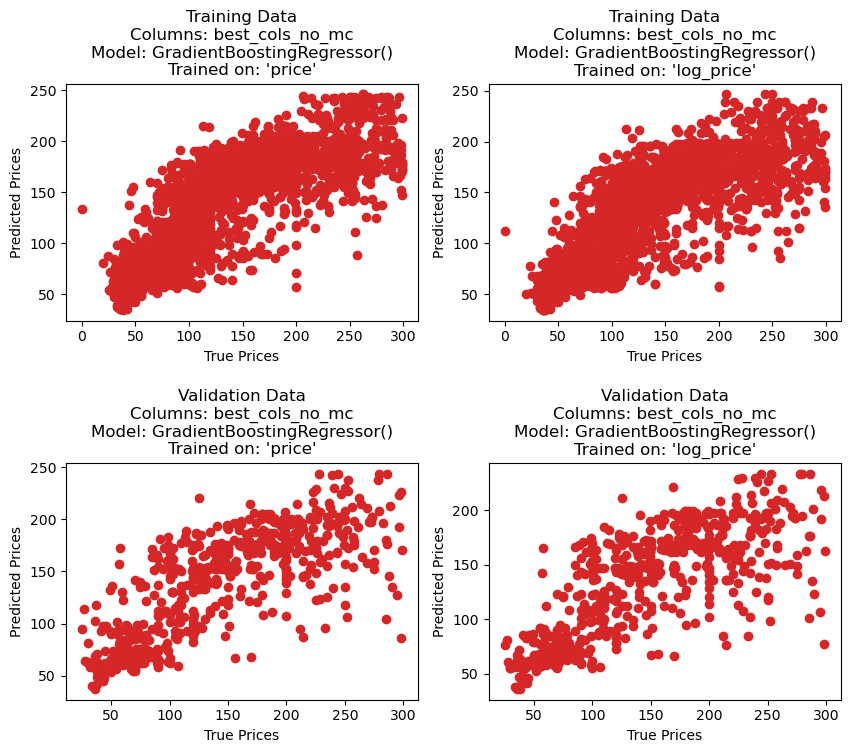



R2 training, price: 0.965
R2 training, log_price: 0.964
RMSE training, price: 12.928
RMSE training, log_price: 13.077

R2 validation, price: 0.533
R2 validation, log_price: 0.525
RMSE validation, price: 47.654
RMSE validation, log_price: 48.072


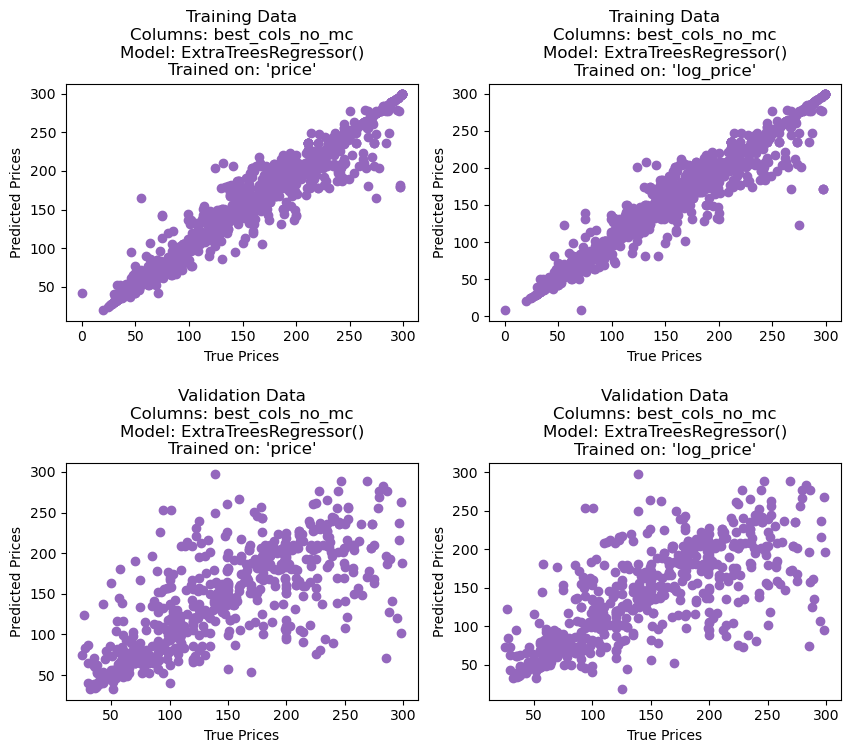



R2 training, price: 0.486
R2 training, log_price: 0.469
RMSE training, price: 49.455
RMSE training, log_price: 50.274

R2 validation, price: 0.488
R2 validation, log_price: 0.414
RMSE validation, price: 49.893
RMSE validation, log_price: 53.385


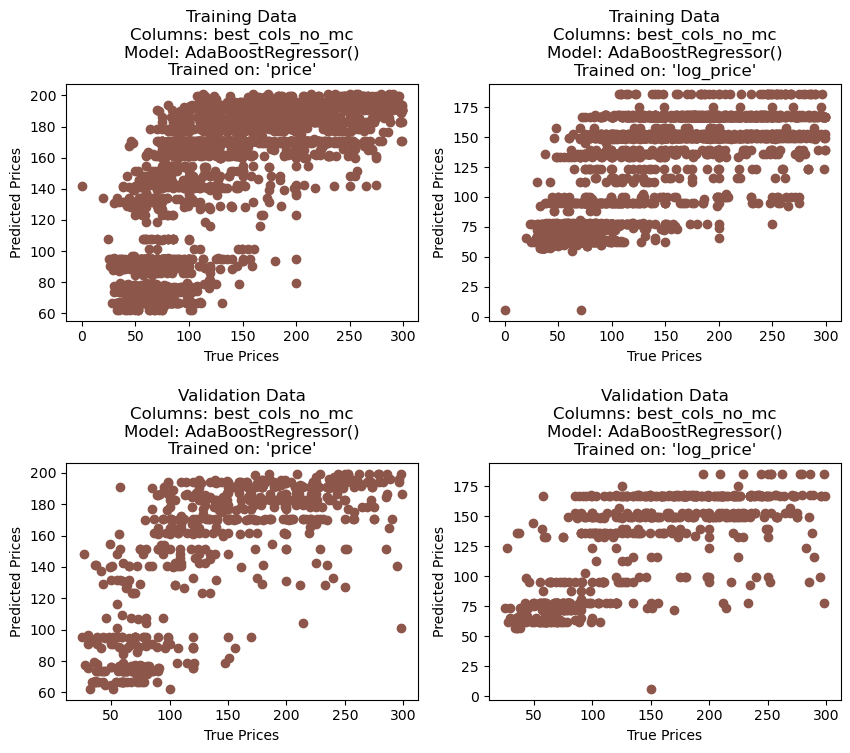



R2 training, price: 0.965
R2 training, log_price: 0.964
RMSE training, price: 12.925
RMSE training, log_price: 13.077

R2 validation, price: 0.324
R2 validation, log_price: 0.414
RMSE validation, price: 57.331
RMSE validation, log_price: 53.391


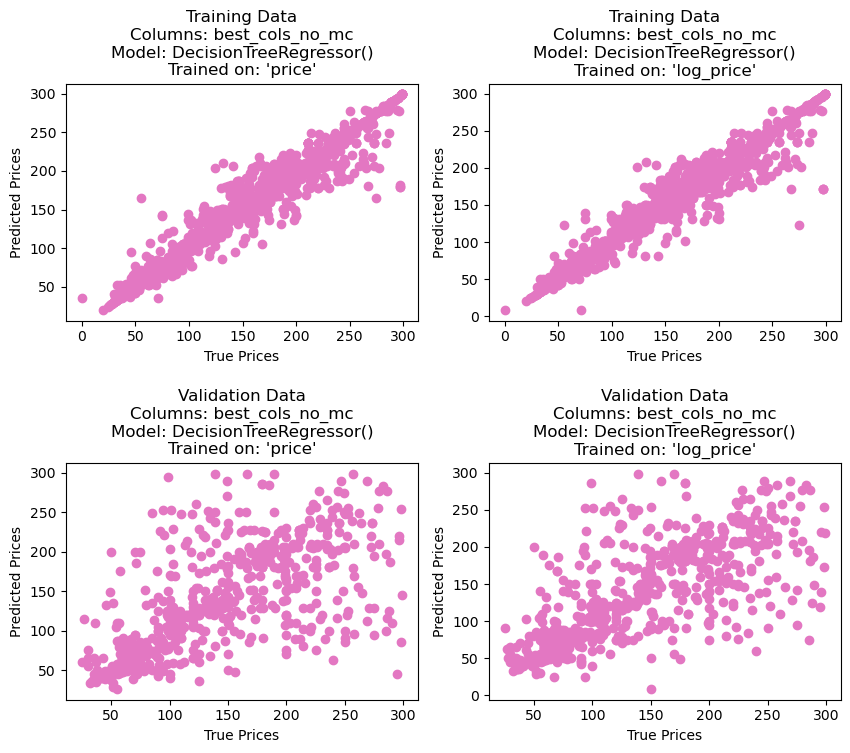

In [23]:
# Run the data maker function inside of the model maker function
model_maker(data_X_maker(lstn[lstn.price < 300], validation[validation.price < 300], best_cols_no_mc, 'best_cols_no_mc'), 
            'best_cols_no_mc', 
            list_of_models)

data_list_best_columns
(2781, 30)


R2 training, price: 0.249
R2 training, log_price: 0.226
RMSE training, price: 180.592
RMSE training, log_price: 183.281

R2 validation, price: 0.038
R2 validation, log_price: 0.04
RMSE validation, price: 399.213
RMSE validation, log_price: 398.652


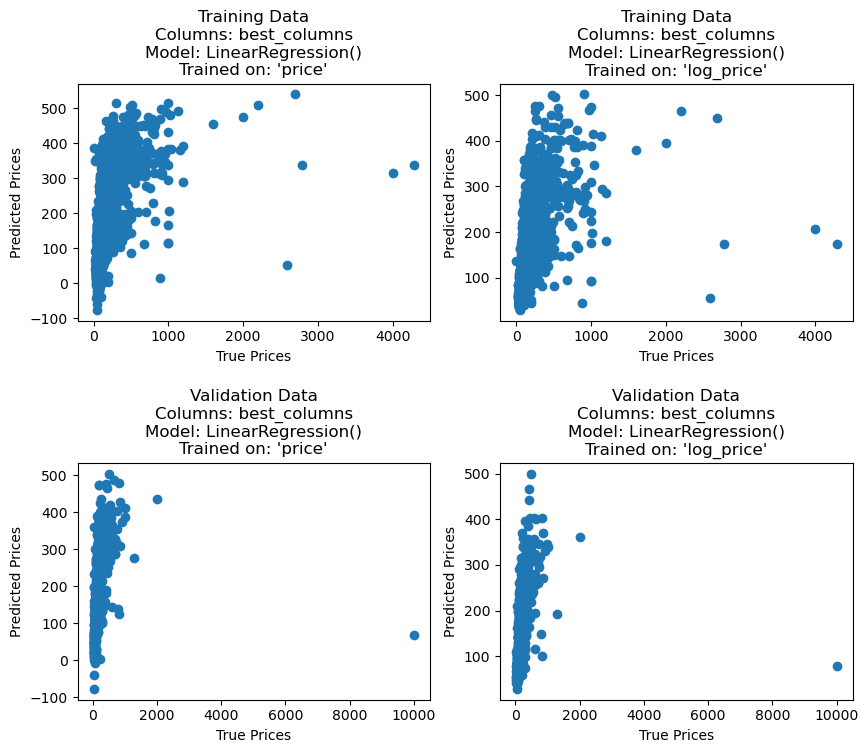



R2 training, price: 0.859
R2 training, log_price: 0.766
RMSE training, price: 78.339
RMSE training, log_price: 100.758

R2 validation, price: 0.049
R2 validation, log_price: 0.055
RMSE validation, price: 396.894
RMSE validation, log_price: 395.62


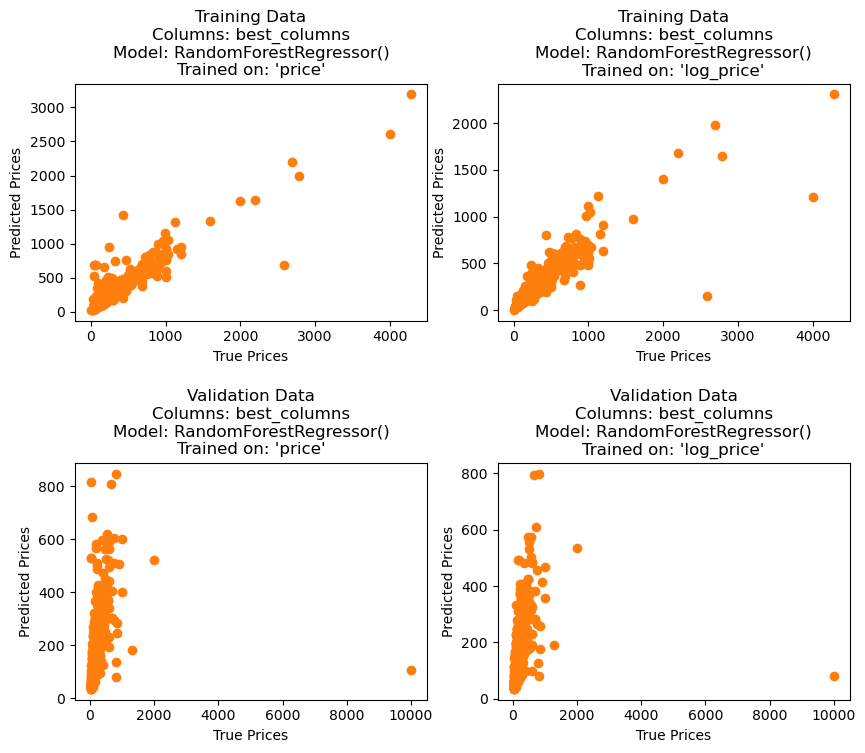



R2 training, price: 0.824
R2 training, log_price: 0.655
RMSE training, price: 87.376
RMSE training, log_price: 122.291

R2 validation, price: 0.054
R2 validation, log_price: 0.05
RMSE validation, price: 395.9
RMSE validation, log_price: 396.578


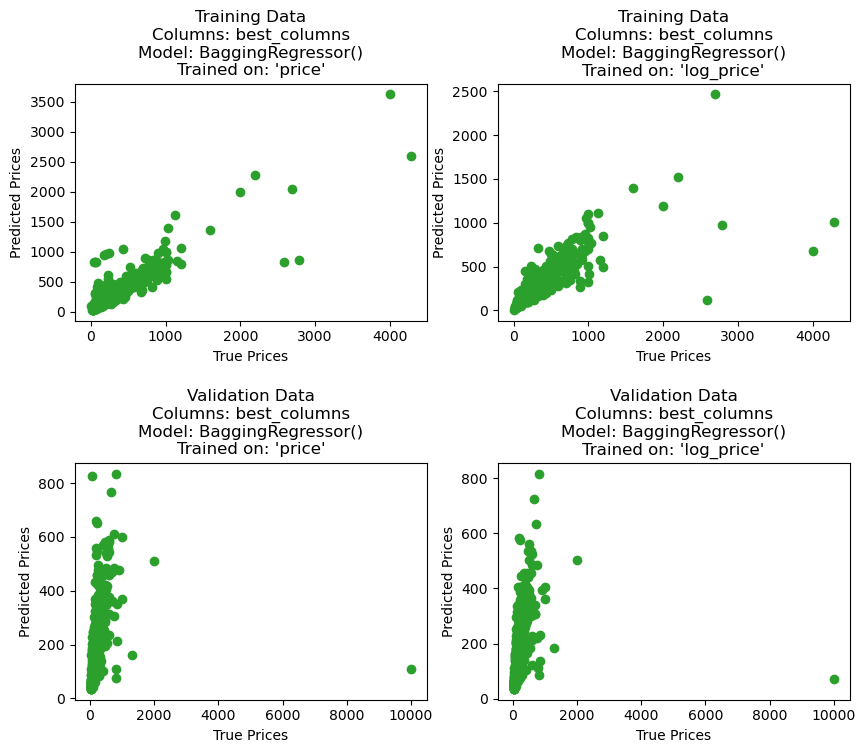



R2 training, price: 0.567
R2 training, log_price: 0.419
RMSE training, price: 137.036
RMSE training, log_price: 158.836

R2 validation, price: 0.062
R2 validation, log_price: 0.055
RMSE validation, price: 394.133
RMSE validation, log_price: 395.685


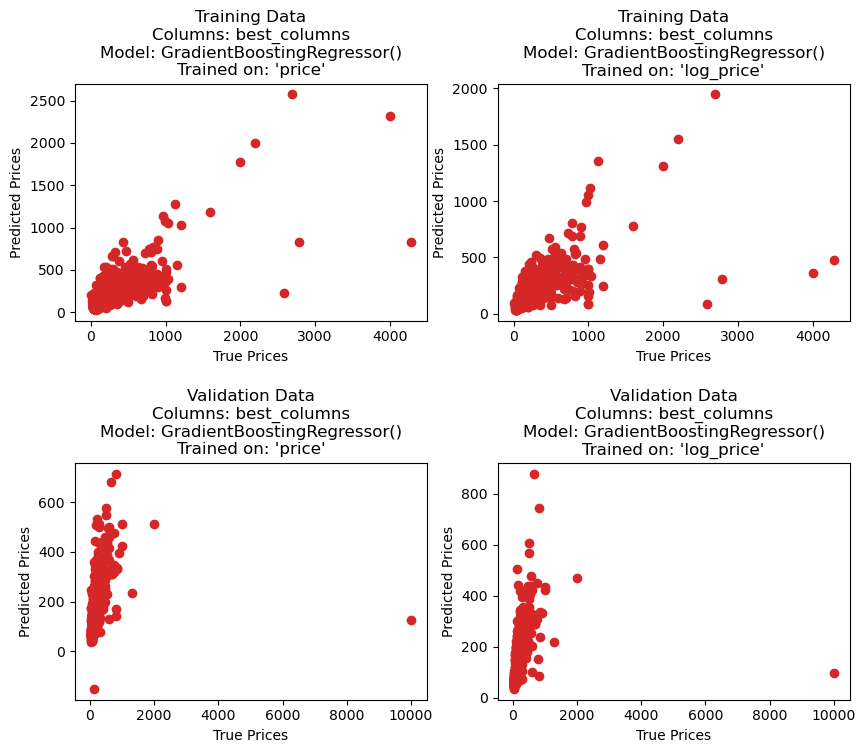



R2 training, price: 0.95
R2 training, log_price: 0.94
RMSE training, price: 46.574
RMSE training, log_price: 51.127

R2 validation, price: 0.036
R2 validation, log_price: 0.055
RMSE validation, price: 399.634
RMSE validation, log_price: 395.644


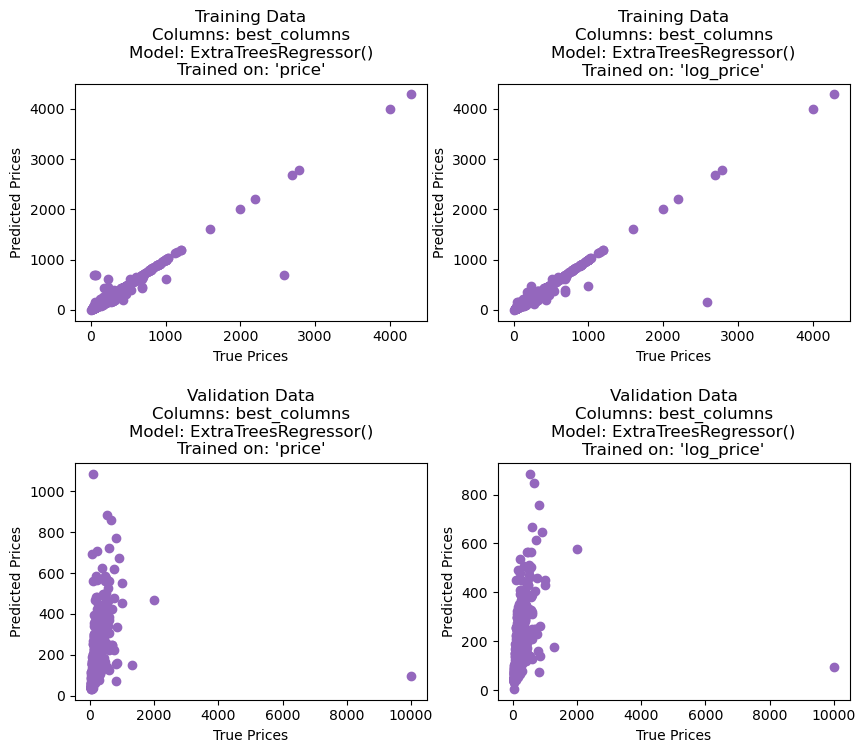



R2 training, price: 0.28
R2 training, log_price: 0.231
RMSE training, price: 176.718
RMSE training, log_price: 182.728

R2 validation, price: 0.007
R2 validation, log_price: 0.022
RMSE validation, price: 405.63
RMSE validation, log_price: 402.394


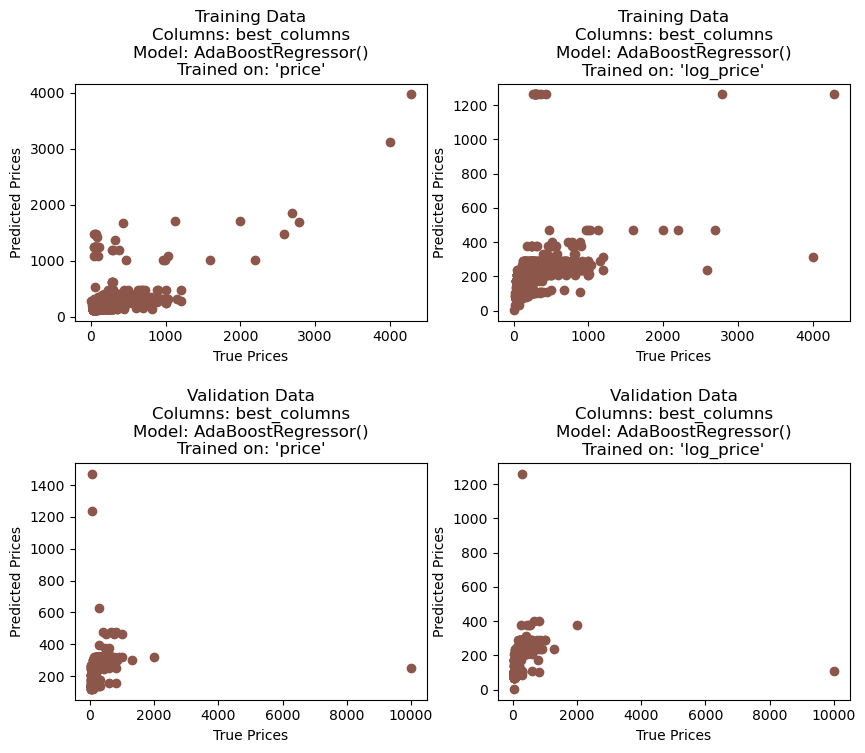



R2 training, price: 0.95
R2 training, log_price: 0.94
RMSE training, price: 46.574
RMSE training, log_price: 51.127

R2 validation, price: 0.032
R2 validation, log_price: 0.023
RMSE validation, price: 400.354
RMSE validation, log_price: 402.256


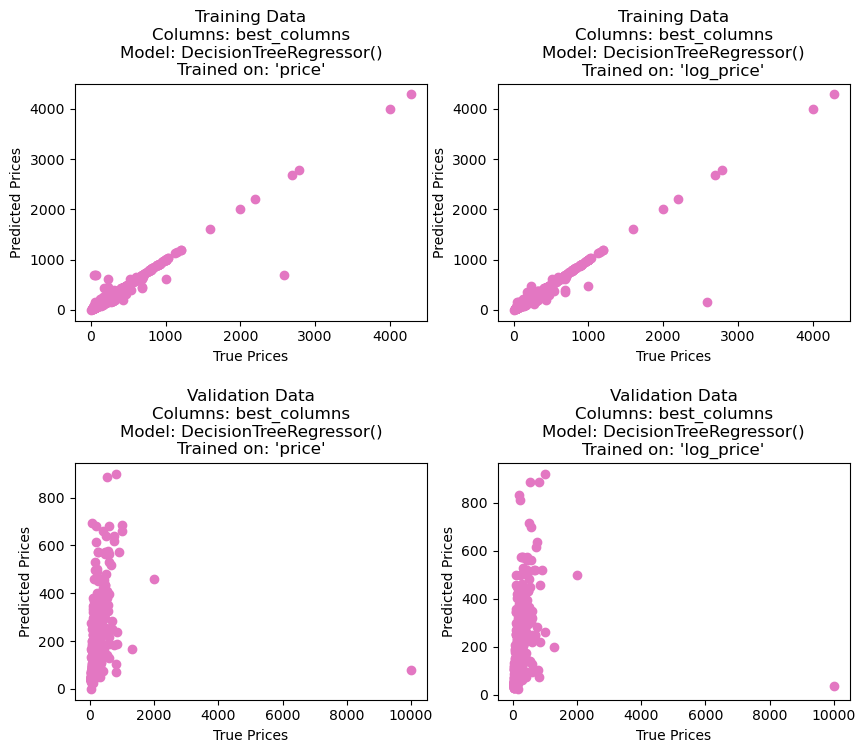

In [24]:
# Run the data maker function inside of the model maker function
model_maker(data_X_maker(lstn, validation, best_columns, 'best_columns'), 
            'best_columns', 
            list_of_models)

In [25]:
lstn.columns[0:11]

Index(['host_since', 'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bedrooms', 'beds', 'price'],
      dtype='object')

data_list_best_columns
(2781, 100)


R2 training, price: 0.411
R2 training, log_price: 0.391
RMSE training, price: 159.934
RMSE training, log_price: 162.534

R2 validation, price: 0.051
R2 validation, log_price: 0.058
RMSE validation, price: 396.472
RMSE validation, log_price: 394.985


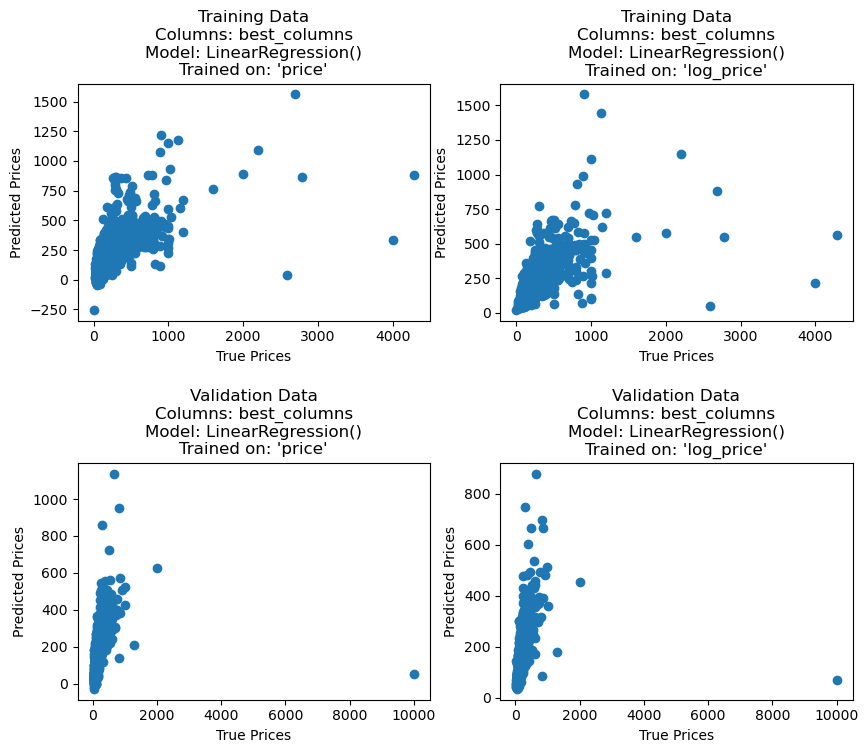



R2 training, price: 0.926
R2 training, log_price: 0.804
RMSE training, price: 56.816
RMSE training, log_price: 92.2

R2 validation, price: 0.054
R2 validation, log_price: 0.067
RMSE validation, price: 395.798
RMSE validation, log_price: 393.162


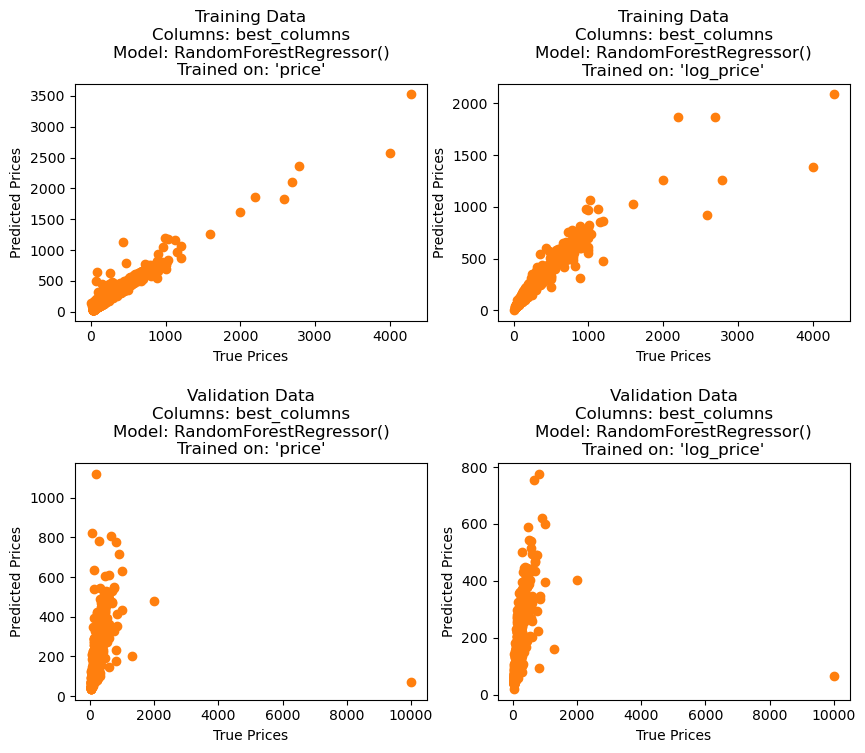



R2 training, price: 0.881
R2 training, log_price: 0.832
RMSE training, price: 71.939
RMSE training, log_price: 85.32

R2 validation, price: 0.052
R2 validation, log_price: 0.061
RMSE validation, price: 396.205
RMSE validation, log_price: 394.353


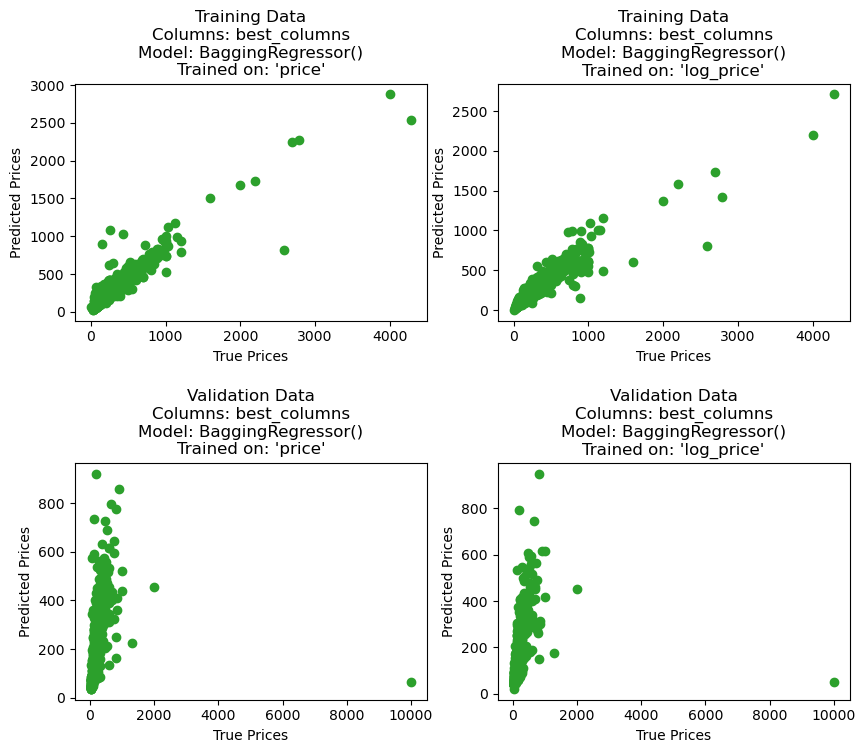



R2 training, price: 0.728
R2 training, log_price: 0.489
RMSE training, price: 108.719
RMSE training, log_price: 148.895

R2 validation, price: 0.061
R2 validation, log_price: 0.066
RMSE validation, price: 394.37
RMSE validation, log_price: 393.389


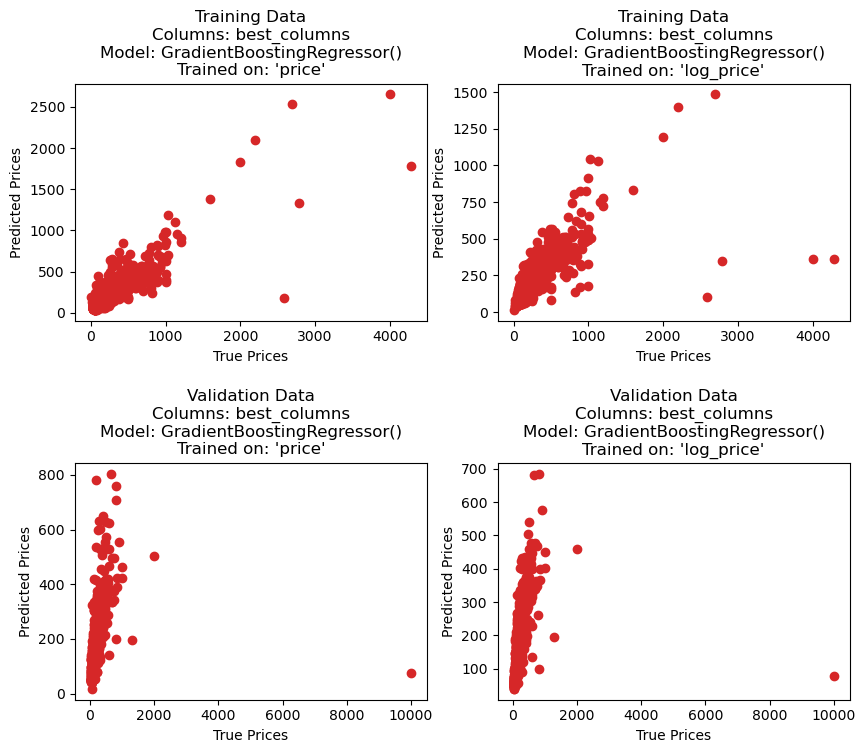



R2 training, price: 1.0
R2 training, log_price: 1.0
RMSE training, price: 0.551
RMSE training, log_price: 0.551

R2 validation, price: 0.073
R2 validation, log_price: 0.076
RMSE validation, price: 391.741
RMSE validation, log_price: 391.279


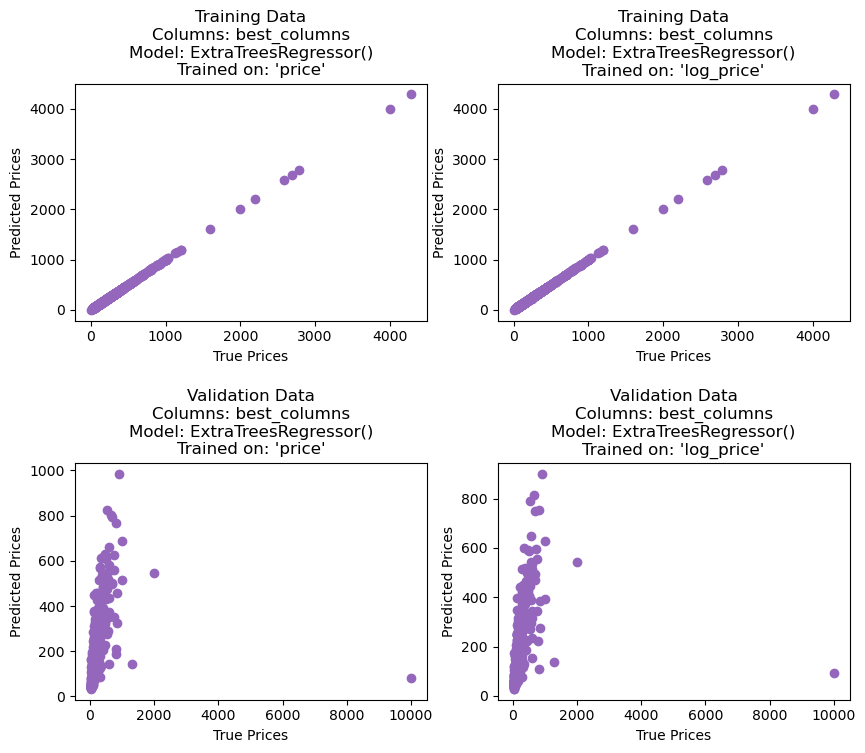



R2 training, price: 0.293
R2 training, log_price: 0.384
RMSE training, price: 175.199
RMSE training, log_price: 163.527

R2 validation, price: -0.02
R2 validation, log_price: 0.037
RMSE validation, price: 410.963
RMSE validation, log_price: 399.452


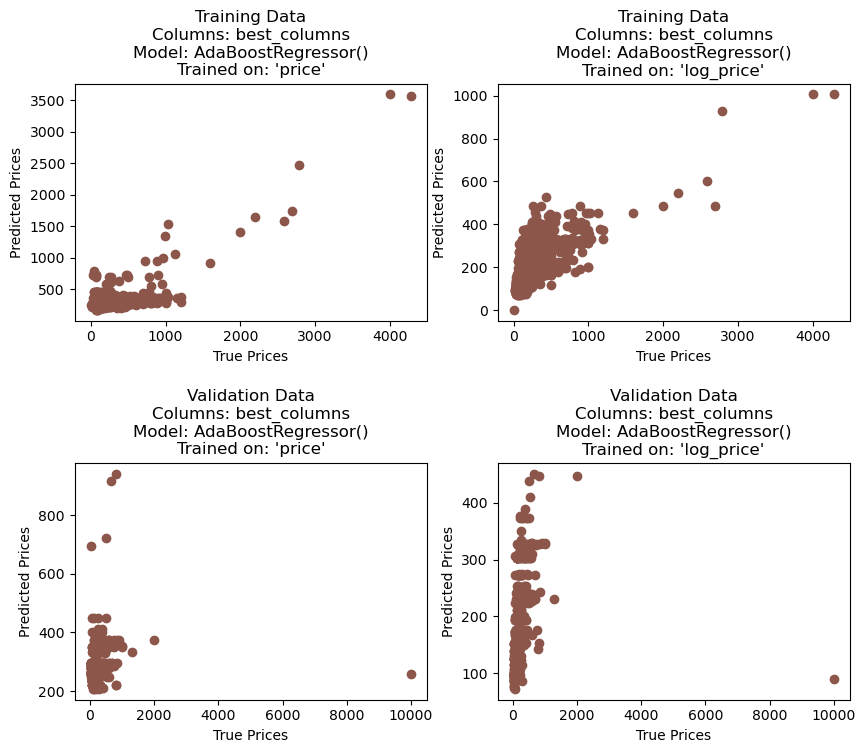



R2 training, price: 1.0
R2 training, log_price: 1.0
RMSE training, price: 0.551
RMSE training, log_price: 0.551

R2 validation, price: -0.185
R2 validation, log_price: 0.005
RMSE validation, price: 443.106
RMSE validation, log_price: 405.983


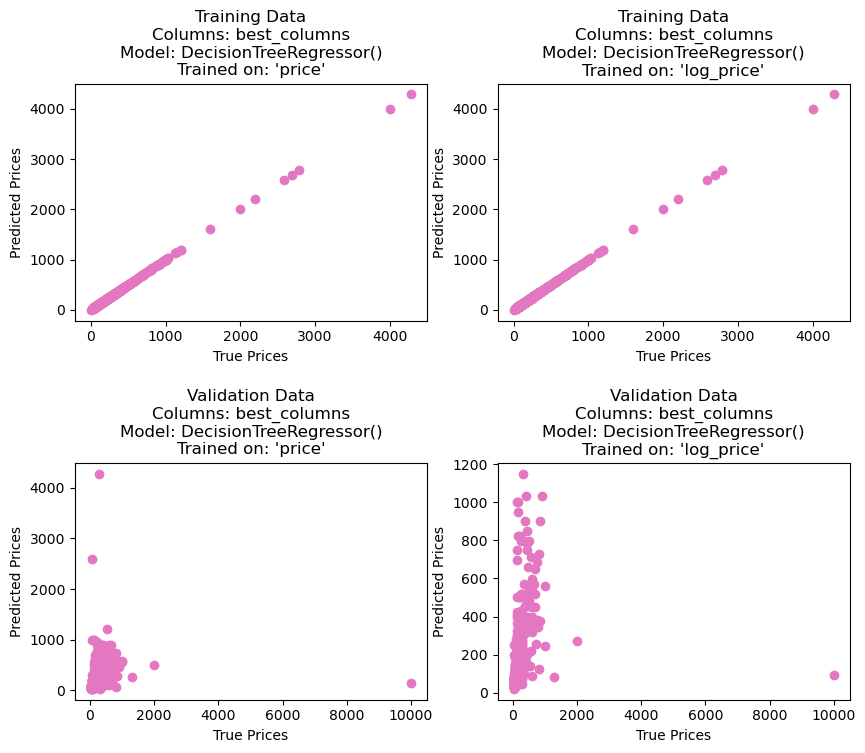

In [26]:
# Run the data maker function inside of the model maker function


super_col_list = list(lstn.columns)
super_col_list.remove('price')
super_col_list.remove('log_price')

model_maker(data_X_maker(lstn,
                         validation,
                         super_col_list[0:100], 
                         'best_columns'
                        ), 
            'best_columns', 
            list_of_models)

---
---
# PCA???

In [419]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA

In [420]:
X_train = lstn.drop(columns=['price', 'log_price'])#.iloc[:, 0:3000]
X_val = validation.drop(columns=['price', 'log_price'])#.iloc[:, 0:3000]

In [421]:
X_train.shape

(2781, 12580)

In [422]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_val_ss = ss.transform(X_val)

In [423]:
pca = PCA(random_state=42)
pca.fit(X_train_ss)

Z_train = pca.transform(X_train_ss)
Z_val = pca.transform(X_val_ss)

In [424]:
y_train, y_val = lstn.price, validation.price

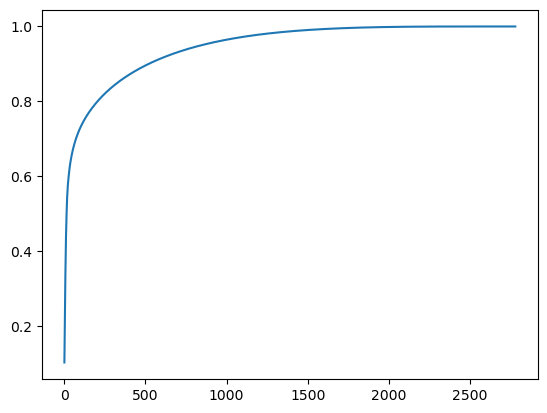

In [425]:
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [429]:
X_train_ss = ss.fit_transform(X_train)
X_val_ss = ss.transform(X_val)

pca = PCA(n_components=80, random_state=42)
pca.fit(X_train_ss)

Z_train = pca.transform(X_train_ss)
Z_val = pca.transform(X_val_ss)

lr_pca = LinearRegression()

lr_pca.fit(Z_train, y_train)
lr_pca.score(Z_train, y_train), lr_pca.score(Z_val, y_val)

(0.21800722624832303, 0.045637480238780004)

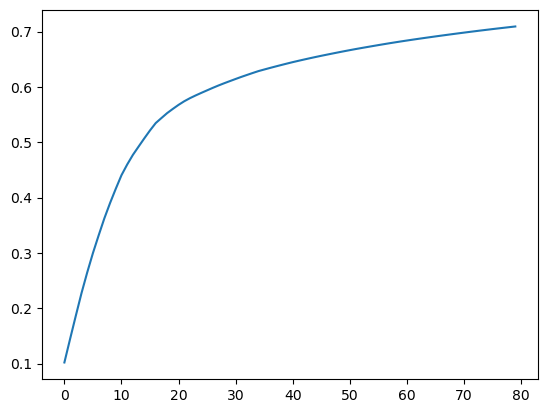

In [427]:
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [378]:
Z_train.shape

(2781, 500)

# This one worked pretty well - only use first 3k columns, and n-80 features

In [410]:
X_train = lstn.drop(columns=['price', 'log_price']).iloc[:, 0:3000]
X_val = validation.drop(columns=['price', 'log_price']).iloc[:, 0:3000]

In [411]:
X_train.shape

(2781, 3000)

In [412]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_val_ss = ss.transform(X_val)

In [413]:
pca = PCA(random_state=42)
pca.fit(X_train_ss)

Z_train = pca.transform(X_train_ss)
Z_val = pca.transform(X_val_ss)

In [414]:
y_train, y_val = lstn.price, validation.price

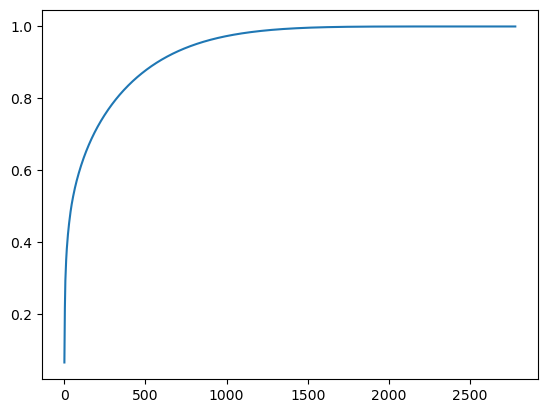

In [415]:
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [417]:
X_train_ss = ss.fit_transform(X_train)
X_val_ss = ss.transform(X_val)

pca = PCA(n_components=80)
pca.fit(X_train_ss)

Z_train = pca.transform(X_train_ss)
Z_val = pca.transform(X_val_ss)

lr_pca = LinearRegression()

lr_pca.fit(Z_train, y_train)
lr_pca.score(Z_train, y_train), lr_pca.score(Z_val, y_val)

(0.312929834384821, 0.06392482859045523)

# JUNK

In [27]:
# '''
# Create a function that will create training and validation datasets based on a list of
# input columns against price and log_price data.  Do this only for the X data, y will 
# always be the same.
# '''

# def data_X_maker(col_list, col_list_name):
#     globals()[f'X_train_{col_list_name}']  = lstn_best[best_cols_no_mc]
#     print(f'X_train_{col_list_name}')
    
#     globals()[f'X_val_{col_list_name}'] = validation[best_cols_no_mc]
#     print(f'X_val_{col_list_name}')

    
    
# def model_maker(X_train_df, X_val_df, col_list_name, mod_list):
    
#     # Create common y datasets:
#     y_train = lstn['price']
#     y_val = validation['price']
    
#     y_train_log = lstn['log_price']
#     y_val_log = validation['log_price']

    
#     color_code = 0
    
#     for model in mod_list:
        
#         # Run Models on price
#         model_inst = model
#         model_inst.fit(X_train_df, y_train)
        
#         # Scores
#         r2_train_price = round(model_inst.score(X_train_df, y_train), 3)
#         r2_val_price = round(model_inst.score(X_val_df, y_val), 3)
        
#         preds_price_train = model_inst.predict(X_train_df)
#         preds_price_val = model_inst.predict(X_val_df)
        
#         # Run models on log price
#         model_inst_log = model
#         model_inst_log.fit(X_train_df, y_train_log)
        
#         # Scores
#         preds_log_price_train = np.exp(model_inst_log.predict(X_train_df))
#         preds_log_price_val = np.exp(model_inst_log.predict(X_val_df))
        
#         r2_train_log_price = round(r2_score(y_train, preds_log_price_train), 3)
#         r2_val_log_price = round(r2_score(y_val, preds_log_price_val), 3)
        
#         print('\n')
#         print('=' * 50)       
#         print(f'R2 training, price: {r2_train_price}')
#         print(f'R2 training, log_price: {r2_train_log_price}\n')
#         #print('\n')
#         print(f'R2 validation, price: {r2_val_price}')
#         print(f'R2 validation, log_price: {r2_val_log_price}')
#         print('=' * 50)
                        
#         plt.figure(figsize = (10, 8))
#         plt.subplots_adjust(hspace=0.55)
        

#         plt.subplot(2, 2, 1)
#         plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
#         plt.scatter(y_train, preds_price_train, color = f'C{color_code}')
#         plt.xlabel('True Prices')
#         plt.ylabel('Predicted Prices')
        
#         plt.subplot(2, 2, 2)
#         plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
#         plt.scatter(y_train, preds_log_price_train, color = f'C{color_code}')
#         plt.xlabel('True Prices')
#         plt.ylabel('Predicted Prices')
        
        
#         plt.subplot(2, 2, 3)
#         plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
#         plt.scatter(y_val, preds_price_val, color = f'C{color_code}')
#         plt.xlabel('True Prices')        
#         plt.ylabel('Predicted Prices')
        
#         plt.subplot(2, 2, 4)
#         plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
#         plt.scatter(y_val, preds_log_price_val, color = f'C{color_code}')
#         plt.xlabel('True Prices')
#         plt.ylabel('Predicted Prices')
        
#         plt.show()
        
#         color_code += 1

In [28]:
# data_X_maker(lstn, validation, best_cols_no_mc, 'best_cols_no_mc');
# model_maker(data_list_best_cols_no_mc, 
#             'best_cols_no_mc', 
#             list_of_models)

# model_maker(X_train_best_cols_no_mc, X_val_best_cols_no_mc, 
#             'best_cols_no_mc', 
#             list_of_models)

In [29]:
# https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
f'{fun=}'.split('=')[0]

NameError: name 'fun' is not defined

In [116]:
'''
Create a function that will create training and validation datasets based on a list of
input columns against price and log_price data.  Do this only for the X data, y will 
always be the same.
'''

def data_X_maker(data_train, data_val, col_list, single_prediction):
    
    col_list_name = f'{col_list=}'
    
    globals()[f'X_train_{col_list_name}']  = data_train[col_list]
    #print(f'X_train_{col_list_name}')
    
    globals()[f'X_val_{col_list_name}'] = data_val[col_list]
    #print(f'X_val_{col_list_name}')
    
    # Create common y datasets:
    globals()[f'y_train_{col_list_name}'] = data_train['price']
    #print(f'y_train_{col_list_name}')
    
    globals()[f'y_train_log_{col_list_name}'] = data_train['log_price']
    #print(f'y_train_log_{col_list_name}')
    
    # Create an if statemetn to skip the creation of certain data for a single prediction
    if single_prediction == True:
        pass
    
    else:
        globals()[f'y_val_{col_list_name}'] = data_val['price']
        #print(f'y_val_{col_list_name}')

        globals()[f'y_val_log_{col_list_name}'] = data_val['log_price']
        #print(f'y_val_log_{col_list_name}')
    
    
    # Create dataframes for modeling:
    globals()[f'data_list_{col_list_name}'] = [
        globals()[f'X_train_{col_list_name}'],
        globals()[f'X_val_{col_list_name}'],
        globals()[f'y_train_{col_list_name}'],
        globals()[f'y_train_log_{col_list_name}'],
    ]
    
    # Ignore y_val's if a single prediction:
    if single_prediction == True:
        pass
    
    else:
        globals()[f'data_list_{col_list_name}'].append(globals()[f'y_val_{col_list_name}'])
        globals()[f'data_list_{col_list_name}'].append(globals()[f'y_val_log_{col_list_name}'])
     
    # Print the name of the list of dataframes for reference
    print(f'data_list_{col_list_name}')
    
    return globals()[f'data_list_{col_list_name}']

def model_maker(data_list, col_list_name, mod_list):
    
    # Detect the length of the dataframe to see if y_val and y_val_log are present
    #  Detects whether or not it's a single predict without asking as an argument
    dl_len = len(data_list)
    
    if dl_len == 4 and len(mod_list) > 1:
        print('HEY!!!!!!  ONLY ONE MODEL PLEASE!!!!!!!!')
    
    else:
        # Import data from a data list grabbing each component by index
        # X Data
        X_train_df = data_list[0]
        X_val_df = data_list[1]

        print(f'{X_train_df.shape}')

        # y datasets:
        y_train = data_list[2]
        y_train_log = data_list[3]

        if dl_len > 4:
            y_val = data_list[4]
            y_val_log = data_list[5]
        else:
            pass

        # This is to change colors for each model so they're easier to identify
        color_code = 0
        
        if dl_len == 4:
            pass
        
        else:
            # This is a dictionary which will house all metrics comupted in this loop
            modeling_dictionary = {'col_data': [], 
                         'model':[], 
                         'R2 training, price': [], 
                         'R2 training, log_price': [], 
                         'RMSE training, price': [],
                         'RMSE training, log_price': [],
                         'R2 validation, price': [],
                         'R2 validation, log_price': [],
                         'RMSE validation, price': [],
                         'RMSE validation, log_price': []                 
                        }

        # Run the for loop to run all models in the input list on the data
        for model in mod_list:

            # **************  PRICE MODEL  ****************************************
            # Run Models on price
            model_inst = model
            model_inst.fit(X_train_df, y_train)
            
            # Scores      
            preds_price_train = model_inst.predict(X_train_df)
            preds_price_val = model_inst.predict(X_val_df)
            
            if dl_len == 4:
                return preds_price_val
            
            else:                
                r2_train_price = round(model_inst.score(X_train_df, y_train), 3)
                r2_val_price = round(r2_score(y_val, preds_price_val), 3)

                rmse_train_price = round(mean_squared_error(y_train, preds_price_train, squared = False), 3)
                rmse_val_price = round(mean_squared_error(y_val, preds_price_val, squared = False), 3)


                # ***************  LOG PRICE MODEL  ***************************************
                # Run models on log price
                model_inst_log = model
                model_inst_log.fit(X_train_df, y_train_log)

                # Scores
                preds_log_price_train = np.exp(model_inst_log.predict(X_train_df))
                preds_log_price_val = np.exp(model_inst_log.predict(X_val_df))

                r2_train_log_price = round(r2_score(y_train, preds_log_price_train), 3)
                r2_val_log_price = round(r2_score(y_val, preds_log_price_val), 3)

                rmse_train_log_price = round(mean_squared_error(y_train, preds_log_price_train, squared = False), 3)
                rmse_val_log_price = round(mean_squared_error(y_val, preds_log_price_val, squared = False), 3)


                # Append values to dictionary:
                modeling_dictionary['col_data'].append(col_list_name)
                modeling_dictionary['model'].append(f'{model}'), 
                modeling_dictionary['R2 training, price'].append(r2_train_price) 
                modeling_dictionary['R2 training, log_price'].append(r2_train_log_price) 
                modeling_dictionary['RMSE training, price'].append(rmse_train_price)
                modeling_dictionary['RMSE training, log_price'].append(rmse_train_log_price)
                modeling_dictionary['R2 validation, price'].append(r2_val_price)
                modeling_dictionary['R2 validation, log_price'].append(r2_val_log_price)
                modeling_dictionary['RMSE validation, price'].append(rmse_val_price)
                modeling_dictionary['RMSE validation, log_price'].append(rmse_val_log_price)

                # Print the metrics so they can be viewed
                print('\n')
                print('=' * 50)       
                print(f'R2 training, price: {r2_train_price}')
                print(f'R2 training, log_price: {r2_train_log_price}')

                print(f'RMSE training, price: {rmse_train_price}')
                print(f'RMSE training, log_price: {rmse_train_log_price}\n')

                #print('\n')
                print(f'R2 validation, price: {r2_val_price}')
                print(f'R2 validation, log_price: {r2_val_log_price}')

                print(f'RMSE validation, price: {rmse_val_price}')
                print(f'RMSE validation, log_price: {rmse_val_log_price}')


                print('=' * 50)

                plt.figure(figsize = (10, 8))
                plt.subplots_adjust(hspace=0.6)

                plt.subplot(2, 2, 1)
                plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
                plt.scatter(y_train, preds_price_train, color = f'C{color_code}')
                plt.xlabel('True Prices')
                plt.ylabel('Predicted Prices')

                plt.subplot(2, 2, 2)
                plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
                plt.scatter(y_train, preds_log_price_train, color = f'C{color_code}')
                plt.xlabel('True Prices')
                plt.ylabel('Predicted Prices')

                plt.subplot(2, 2, 3)
                plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
                plt.scatter(y_val, preds_price_val, color = f'C{color_code}')
                plt.xlabel('True Prices')        
                plt.ylabel('Predicted Prices')

                plt.subplot(2, 2, 4)
                plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
                plt.scatter(y_val, preds_log_price_val, color = f'C{color_code}')
                plt.xlabel('True Prices')
                plt.ylabel('Predicted Prices')

                plt.show()

                # Up the color code for the next model
                color_code += 1

            '''
            The follwoing formatting code was inspired by the following sources:
            * My project 3
            * https://www.geeksforgeeks.org/highlight-the-maximum-value-in-each-column-in-pandas/
            * https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.highlight_max.html
            * Assking ChatGPT:  "i need an example of using the subset argument in a pandas dataframe formatted with style.highlight_max"
            * https://medium.com/gustavorsantos/how-to-highlight-max-min-or-nulls-with-pandas-f2df5bf4ccf9
            '''
            return pd.DataFrame(modeling_dictionary).style\
        .highlight_max(subset = ['R2 training, price', 'R2 training, log_price', 'R2 validation, price', 'R2 validation, log_price'], color = 'darkred')\
        .highlight_min(subset = ['RMSE training, price', 'RMSE training, log_price', 'RMSE validation, price', 'RMSE validation, log_price'], color = 'blue')

In [227]:
# for the variables, remove the prefixes and replace all spaces

var_list = []

for i in coding_list:
#     var_list.append('listing_ft_returner('+i.replace('neighbourhood_cleansed_', '')\
#                     .replace(' ', '_').replace('amen_', '')\
#                     .replace('\\u2019', '').lower() + ')' + ' = []')
    
    var_list.append(i.replace('neighbourhood_cleansed_', '')\
                .replace(' ', '_').replace('amen_', '')\
                .replace('\\u2019', '').lower() + ' = []')

# for the columns, add brackets and the word 'rec_data' in front to all the colmns
rec_col_list = []

for col in coding_list:
    rec_col_list.append(f'rec_data["{col}"]')

# Finally, join them together using indexes, add a carriage return at the end of each

codez = []

for index in range(len(var_list)):
    codez.append(f'{rec_col_list[index]} = {var_list[index]}')

In [173]:
rec_cols = ['accommodates', 
'bedrooms', 
'beds', 
'minimum_nights',
'room_type_Hotel room',
'room_type_Private room', 
'room_type_Shared room',
'has_availability_t']

In [211]:
coding_list = [
    'minimum_nights'
    'room_type_Hotel room',
    'room_type_Private room', 
    'room_type_Shared room',
    'has_availability_t', 
    'neighbourhood_cleansed_Back Bay',
    'neighbourhood_cleansed_Bay Village',
    'neighbourhood_cleansed_Beacon Hill', 
    'neighbourhood_cleansed_Brighton',
    'neighbourhood_cleansed_Charlestown',
    'neighbourhood_cleansed_Chinatown', 
    'neighbourhood_cleansed_Dorchester',
    'neighbourhood_cleansed_Downtown', 
    'neighbourhood_cleansed_East Boston',
    'neighbourhood_cleansed_Fenway', 
    'neighbourhood_cleansed_Hyde Park',
    'neighbourhood_cleansed_Jamaica Plain',
    'neighbourhood_cleansed_Leather District',
    'neighbourhood_cleansed_Longwood Medical Area',
    'neighbourhood_cleansed_Mattapan',
    'neighbourhood_cleansed_Mission Hill',
    'neighbourhood_cleansed_North End', 
    'neighbourhood_cleansed_Roslindale',
    'neighbourhood_cleansed_Roxbury', 
    'neighbourhood_cleansed_South Boston',
    'neighbourhood_cleansed_South Boston Waterfront',
    'neighbourhood_cleansed_South End', 
    'neighbourhood_cleansed_West End',
    'neighbourhood_cleansed_West Roxbury', 
    'amen_Wifi',
    'amen_Kitchen',
    'amen_Essentials',
    'amen_Dedicated workspace',
    'amen_Pets allowed',
    'amen_Gym',
    'amen_Indoor fireplace',
    'amen_Indoor fireplace: electric',
    'amen_Fire pit',
    'amen_Waterfront',
    'amen_Free street parking',
    'amen_Free parking on premises',
    'amen_Patio or balcony',
    'amen_Backyard',
    'amen_BBQ grill',
    'amen_Private patio or balcony',
    'amen_Outdoor dining area',
    'amen_Pack \\u2019n play/Travel crib',
    'amen_Children\\u2019s books and toys',
    'amen_Board games',
    'amen_Window guards',
    'amen_High chair'
]

In [79]:
cosine_similarity([[1, 0, 100], [1, 0, 0]])

array([[1.       , 0.0099995],
       [0.0099995, 1.       ]])

In [281]:
cosine_similarity([(rec_data.iloc[0]), 
                   (lstn[rec_data.columns].iloc[0])])[0][1]

0.9988681377244376

In [453]:
'''
Create a function that will create training and validation datasets based on a list of
input columns against price and log_price data.  Do this only for the X data, y will 
always be the same.
'''

def data_X_maker(data_train, data_val, col_list, col_list_name):
    globals()[f'X_train_{col_list_name}']  = data_train[col_list]
    #print(f'X_train_{col_list_name}')
    
    globals()[f'X_val_{col_list_name}'] = data_val[col_list]
    #print(f'X_val_{col_list_name}')
    
    # Create common y datasets:
    globals()[f'y_train_{col_list_name}'] = data_train['price']
    #print(f'y_train_{col_list_name}')
    
    globals()[f'y_val_{col_list_name}'] = data_val['price']
    #print(f'y_val_{col_list_name}')
    
    globals()[f'y_train_log_{col_list_name}'] = data_train['log_price']
    #print(f'y_train_log_{col_list_name}')
    
    globals()[f'y_val_log_{col_list_name}'] = data_val['log_price']
    #print(f'y_val_log_{col_list_name}')
    
    globals()[f'data_list_{col_list_name}'] = [
        globals()[f'X_train_{col_list_name}'],
        globals()[f'X_val_{col_list_name}'],
        globals()[f'y_train_{col_list_name}'],
        globals()[f'y_val_{col_list_name}'],
        globals()[f'y_train_log_{col_list_name}'],
        globals()[f'y_val_log_{col_list_name}']
    ]
    print(f'data_list_{col_list_name}')
    
    return globals()[f'data_list_{col_list_name}']

def model_maker(data_list, col_list_name, mod_list):
    
    # Import data from a data list grabbing each component by index
    # X Data
    X_train_df = data_list[0]
    X_val_df = data_list[1]
    
    print(f'{X_train_df.shape}')
    
    # y datasets:
    y_train = data_list[2]
    y_val = data_list[3]
    
    y_train_log = data_list[4]
    y_val_log = data_list[5]

    # This is to change colors for each model so they're easier to identify
    color_code = 0
    
    # This is a dictionary which will house all metrics comupted in this loop
    modeling_dictionary = {'col_data': [], 
                 'model':[], 
                 'R2 training, price': [], 
                 'R2 training, log_price': [], 
                 'RMSE training, price': [],
                 'RMSE training, log_price': [],
                 'R2 validation, price': [],
                 'R2 validation, log_price': [],
                 'RMSE validation, price': [],
                 'RMSE validation, log_price': []                 
                }

    # Run the for loop to run all models in the input list on the data
    for model in mod_list:
        
        # **************  PRICE MODEL  ****************************************
        # Run Models on price
        model_inst = model
        model_inst.fit(X_train_df, y_train)
        
        # Scores      
        preds_price_train = model_inst.predict(X_train_df)
        preds_price_val = model_inst.predict(X_val_df)
        
        r2_train_price = round(model_inst.score(X_train_df, y_train), 3)
        r2_val_price = round(r2_score(y_val, preds_price_val), 3)
        
        #r2_val_log_price = round(r2_score(y_val, preds_log_price_val), 3)
        
        
        rmse_train_price = round(mean_squared_error(y_train, preds_price_train, squared = False), 3)
        rmse_val_price = round(mean_squared_error(y_val, preds_price_val, squared = False), 3)
        
        
        # ***************  LOG PRICE MODEL  ***************************************
        # Run models on log price
        model_inst_log = model
        model_inst_log.fit(X_train_df, y_train_log)
        
        # Scores
        preds_log_price_train = np.exp(model_inst_log.predict(X_train_df))
        preds_log_price_val = np.exp(model_inst_log.predict(X_val_df))
        
        r2_train_log_price = round(r2_score(y_train, preds_log_price_train), 3)
        r2_val_log_price = round(r2_score(y_val, preds_log_price_val), 3)

        rmse_train_log_price = round(mean_squared_error(y_train, preds_log_price_train, squared = False), 3)
        rmse_val_log_price = round(mean_squared_error(y_val, preds_log_price_val, squared = False), 3)
        
        
        # Append values to dictionary:
        modeling_dictionary['col_data'].append(col_list_name)
        modeling_dictionary['model'].append(f'{model}'), 
        modeling_dictionary['R2 training, price'].append(r2_train_price) 
        modeling_dictionary['R2 training, log_price'].append(r2_train_log_price) 
        modeling_dictionary['RMSE training, price'].append(rmse_train_price)
        modeling_dictionary['RMSE training, log_price'].append(rmse_train_log_price)
        modeling_dictionary['R2 validation, price'].append(r2_val_price)
        modeling_dictionary['R2 validation, log_price'].append(r2_val_log_price)
        modeling_dictionary['RMSE validation, price'].append(rmse_val_price)
        modeling_dictionary['RMSE validation, log_price'].append(rmse_val_log_price)

        # Print the metrics so they can be viewed
        print('\n')
        print('=' * 50)       
        print(f'R2 training, price: {r2_train_price}')
        print(f'R2 training, log_price: {r2_train_log_price}')
        
        print(f'RMSE training, price: {rmse_train_price}')
        print(f'RMSE training, log_price: {rmse_train_log_price}\n')
        
        #print('\n')
        print(f'R2 validation, price: {r2_val_price}')
        print(f'R2 validation, log_price: {r2_val_log_price}')
        
        print(f'RMSE validation, price: {rmse_val_price}')
        print(f'RMSE validation, log_price: {rmse_val_log_price}')
        
        
        print('=' * 50)
                        
        plt.figure(figsize = (10, 8))
        plt.subplots_adjust(hspace=0.6)
        
        plt.subplot(2, 2, 1)
        plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
        plt.scatter(y_train, preds_price_train, color = f'C{color_code}')
        plt.xlabel('True Prices')
        plt.ylabel('Predicted Prices')
        
        plt.subplot(2, 2, 2)
        plt.title(f"Training Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
        plt.scatter(y_train, preds_log_price_train, color = f'C{color_code}')
        plt.xlabel('True Prices')
        plt.ylabel('Predicted Prices')
        
        plt.subplot(2, 2, 3)
        plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'price'")
        plt.scatter(y_val, preds_price_val, color = f'C{color_code}')
        plt.xlabel('True Prices')        
        plt.ylabel('Predicted Prices')
        
        plt.subplot(2, 2, 4)
        plt.title(f"Validation Data\nColumns: {col_list_name}\nModel: {model}\nTrained on: 'log_price'")
        plt.scatter(y_val, preds_log_price_val, color = f'C{color_code}')
        plt.xlabel('True Prices')
        plt.ylabel('Predicted Prices')
        
        plt.show()
        
        # Up the color code for the next model
        color_code += 1
    
    '''
    The follwoing formatting code was inspired by the following sources:
    * My project 3
    * https://www.geeksforgeeks.org/highlight-the-maximum-value-in-each-column-in-pandas/
    * https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.highlight_max.html
    * Assking ChatGPT:  "i need an example of using the subset argument in a pandas dataframe formatted with style.highlight_max"
    * https://medium.com/gustavorsantos/how-to-highlight-max-min-or-nulls-with-pandas-f2df5bf4ccf9
    '''
    return pd.DataFrame(modeling_dictionary).style\
.highlight_max(subset = ['R2 training, price', 'R2 training, log_price', 'R2 validation, price', 'R2 validation, log_price'], color = 'darkred')\
.highlight_min(subset = ['RMSE training, price', 'RMSE training, log_price', 'RMSE validation, price', 'RMSE validation, log_price'], color = 'blue')

In [6]:
# Create a dataframe sorted by the correlation magnitude
corr_df_sorted = corr_df.sort_values(by = 'magnitude', ascending=False)

# Create an empty list to store the column names
best_columns = []

# Create an index to loop through
bc_index = 0

# Write a while loop to get the top 30 most highly correlated columns which are
#  not already duplicated in the list with either their log or non-log counterparts
while len(best_columns) < 30:
    
    # simplify the name of the individual column names pulled out of the df index
    next_column = corr_df_sorted.index[bc_index]
    
    # If the log version not is already there, and if the non-log version of the colunm
    #  name are not already there, then add the column name
    if f'log_{next_column}' not in best_columns and next_column.replace('log_', '') not in best_columns:
        best_columns.append(next_column)
    
    # Increase the index value by 1
    bc_index += 1
    
    

In [10]:
best_cols_no_mc = [best_columns[0]]

for col in best_columns:
    # print(best_cols_no_mc)
    # print(col)
    corrcoefs = []
    
    for col_no_mc in best_cols_no_mc:
        #print(col_no_mc)
        corr_mc = np.corrcoef(lstn[col], lstn[col_no_mc])[0][1]
        corrcoefs.append(abs(corr_mc))
        #print(f'{col} vs. {col_no_mc}: {corr_mc}')
    
    # Set a multi-collinearity correlation coefficient limit and only accept features
    #  with correlation coefficients less than this value
    if max(corrcoefs) < 0.7:
        best_cols_no_mc.append(col)